# Another attempt at fitting splines with PyMC3

## Setup

In [1]:
import re
from dataclasses import dataclass
from pathlib import Path
from typing import Optional

import arviz as az
import janitor  # noqa: F401
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotnine as gg
import pymc as pm
import pymc.math as pmmath
import scipy.stats as st
import seaborn as sns
from aesara import tensor as at
from patsy import DesignMatrix, build_design_matrices, dmatrix

In [3]:
pm.__version__

'4.0.0b2'

In [4]:
# Set default theme for 'plotnine'.
gg.theme_set(gg.theme_minimal() + gg.theme(figure_size=(8, 4)))
%matplotlib inline
%config InlineBackend.figure_format='retina'

# Constants
RANDOM_SEED = 847
HDI_PROB = 0.89

## One group

### Data

In [423]:
@dataclass
class ModelData:
    """Modeling data."""

    data: pd.DataFrame
    B: DesignMatrix
    knots: np.ndarray

In [424]:
def diff_of_gaussians(
    x: np.ndarray,
    mus: tuple[float, float],
    sds: tuple[float, float],
    noise: float,
    y_offset: float = 0.0,
) -> pd.DataFrame:
    y = (
        st.norm.pdf(x, mus[0], sds[0])
        - st.norm.pdf(x, mus[1], sds[1])
        + np.random.normal(0, noise, size=len(x))
    )
    return pd.DataFrame({"x": x, "y": y + y_offset})

In [425]:
group_pal = {"a": "#1F77B4", "b": "#FF7F0E"}

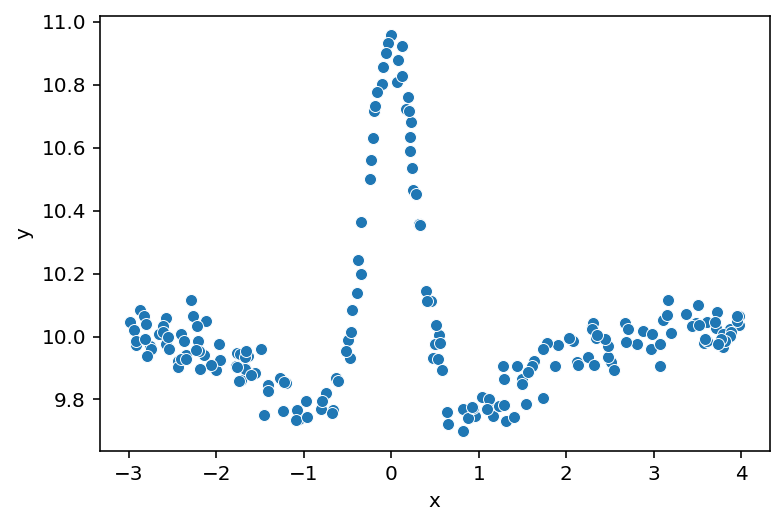

In [426]:
np.random.seed(RANDOM_SEED)

x = np.random.uniform(-3, 4, 200)
_data = diff_of_gaussians(x, (0, 0), (0.3, 1), 0.05, y_offset=10)

sns.scatterplot(data=_data, x="x", y="y");

### Spline basis

In [427]:
def _make_knot_list(data: pd.DataFrame, num_knots: int = 10) -> np.ndarray:
    return np.quantile(data.x, np.linspace(0, 1, num_knots))


def _build_spline(
    data: pd.DataFrame,
    knot_list: Optional[np.ndarray] = None,
    num_knots: int = 10,
    intercept: bool = False,
) -> tuple[np.ndarray, DesignMatrix]:
    if knot_list is None:
        knot_list = _make_knot_list(data, num_knots)

    B = dmatrix(
        f"0 + bs(x, knots=knots, degree=3, include_intercept={intercept})",
        {"x": data.x.values, "knots": knot_list[1:-1]},
    )
    return knot_list, B

In [442]:
_knots, _B = _build_spline(_data, intercept=False)
single_curve_data = ModelData(data=_data, B=_B, knots=_knots)

In [443]:
single_curve_data.knots

array([-2.98089976, -2.36504627, -1.67490314, -0.72551484, -0.04744339,
        0.50477523,  1.30390392,  2.31655179,  3.43279987,  3.97389701])

In [444]:
single_curve_data.B

DesignMatrix with shape (200, 11)
  Columns:
    ['bs(x, knots=knots, degree=3, include_intercept=False)[0]',
     'bs(x, knots=knots, degree=3, include_intercept=False)[1]',
     'bs(x, knots=knots, degree=3, include_intercept=False)[2]',
     'bs(x, knots=knots, degree=3, include_intercept=False)[3]',
     'bs(x, knots=knots, degree=3, include_intercept=False)[4]',
     'bs(x, knots=knots, degree=3, include_intercept=False)[5]',
     'bs(x, knots=knots, degree=3, include_intercept=False)[6]',
     'bs(x, knots=knots, degree=3, include_intercept=False)[7]',
     'bs(x, knots=knots, degree=3, include_intercept=False)[8]',
     'bs(x, knots=knots, degree=3, include_intercept=False)[9]',
     'bs(x, knots=knots, degree=3, include_intercept=False)[10]']
  Terms:
    'bs(x, knots=knots, degree=3, include_intercept=False)' (columns 0:11)
  (to view full data, use np.asarray(this_obj))

In [445]:
np.asarray(single_curve_data.B).shape

(200, 11)

In [446]:
single_curve_data.data.shape

(200, 2)

In [447]:
def _plot_spline_basis(model_data: ModelData) -> gg.ggplot:
    basis_df = (
        pd.DataFrame(model_data.B)
        .reset_index(drop=False)
        .assign(x=model_data.data.x.values)
        .pivot_longer(index=["index", "x"], names_to="basis", values_to="density")
    )

    return (
        gg.ggplot(basis_df, gg.aes(x="x", y="density", color="basis"))
        + gg.geom_line()
        + gg.geom_vline(xintercept=model_data.knots, color="gray", linetype="--")
        + gg.theme(legend_position="none")
    )

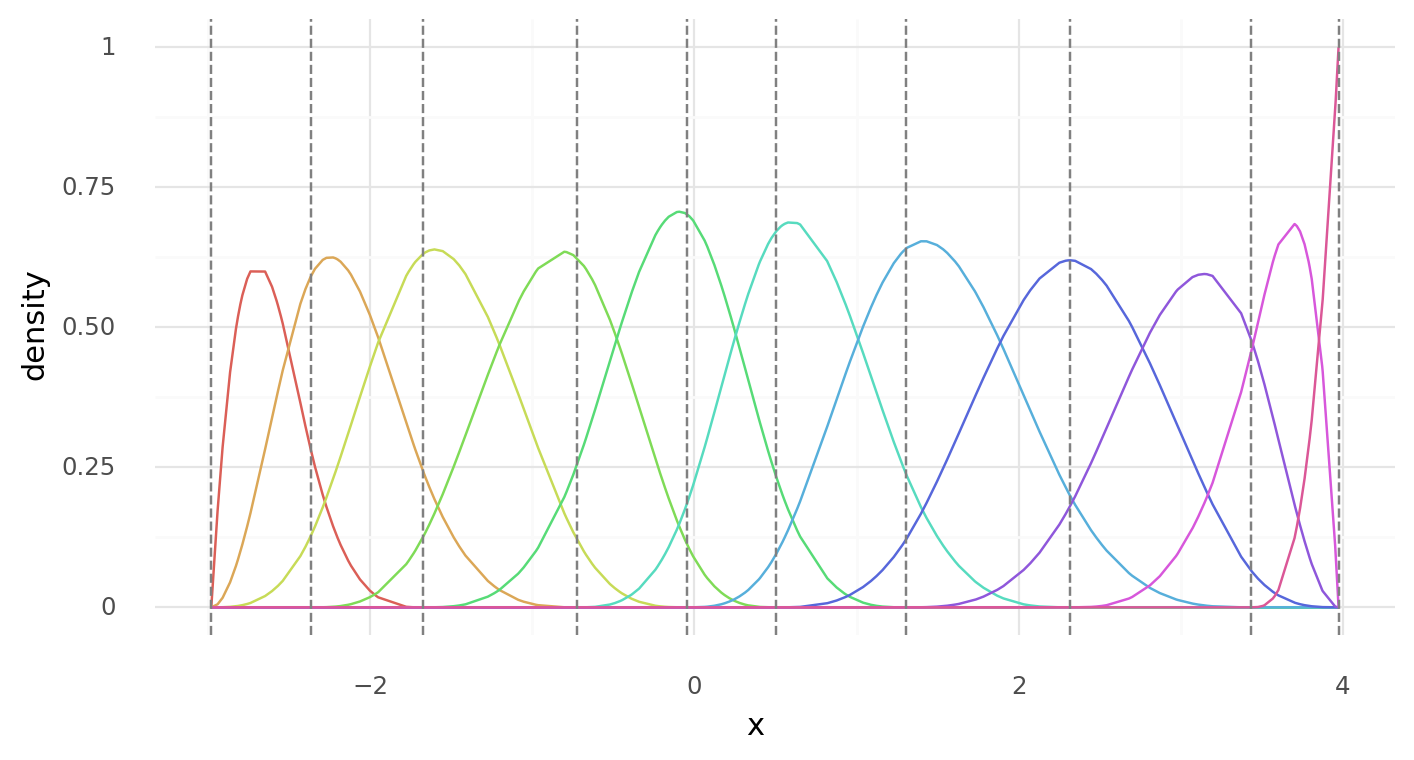

<ggplot: (363047063)>

In [448]:
_plot_spline_basis(single_curve_data)

### Model #1

In [435]:
def build_model1(model_data: ModelData) -> pm.Model:
    df = model_data.data
    B = np.asarray(model_data.B)
    B_dim = B.shape[1]
    with pm.Model(rng_seeder=RANDOM_SEED) as m1:
        a = pm.Normal("a", 0, 5)
        w = pm.Normal("w", 0, 5, shape=B_dim)
        mu = pm.Deterministic("mu", a + pmmath.dot(B, w.T))
        sigma = pm.Gamma("sigma", 2, 0.5)
        y = pm.Normal("y", mu, sigma, observed=df.y)
    return m1

### Prior predictive

In [436]:
def _build_new_data(model_data: ModelData, n_x: int = 500) -> ModelData:
    x = model_data.data.x
    new_data = pd.DataFrame({"x": np.linspace(x.min(), x.max(), num=n_x)}).assign(y=0)
    new_B = build_design_matrices(
        [model_data.B.design_info],
        {"x": new_data.x.values, "knots": model_data.knots[1:-1]},
    )[0]
    return ModelData(data=new_data, B=new_B, knots=model_data.knots.copy())

In [437]:
def _plot_prior(
    prior_pred: az.InferenceData, var_name: str, data: pd.DataFrame, alpha: float = 1.0
) -> None:
    if var_name == "y":
        var_prior = prior_pred.prior_predictive[var_name].values
    else:
        var_prior = prior_pred.prior[var_name].values
    var_prior = var_prior.squeeze()
    prior_df = (
        pd.DataFrame(var_prior.T)
        .reset_index(drop=False)
        .assign(x=data.x)
        .pivot_longer(["index", "x"], names_to="prior_sample")
        .astype({"prior_sample": str})
    )

    sns.lineplot(
        data=prior_df, x="x", y="value", hue="prior_sample", legend=None, alpha=alpha
    )
    plt.show()

In [438]:
new_single_curve_data = _build_new_data(single_curve_data)

In [439]:
with build_model1(new_single_curve_data):
    m1_prior_pred = pm.sample_prior_predictive(samples=10, return_inferencedata=True)

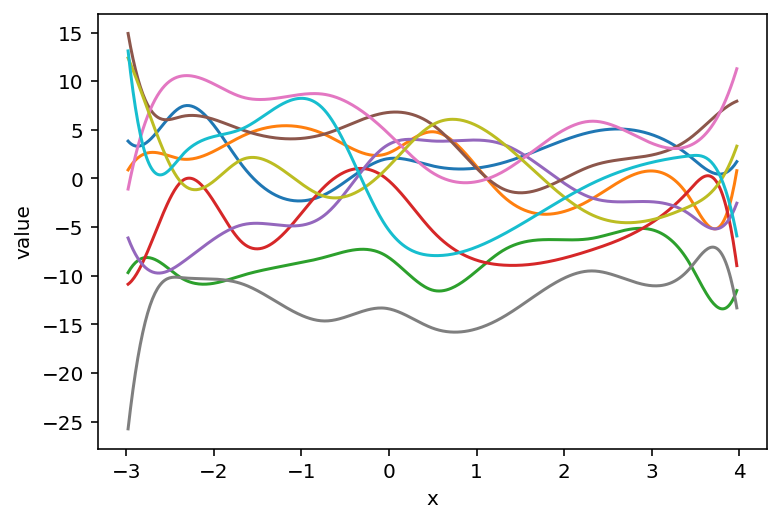

In [440]:
_plot_prior(m1_prior_pred, "mu", data=new_single_curve_data.data)

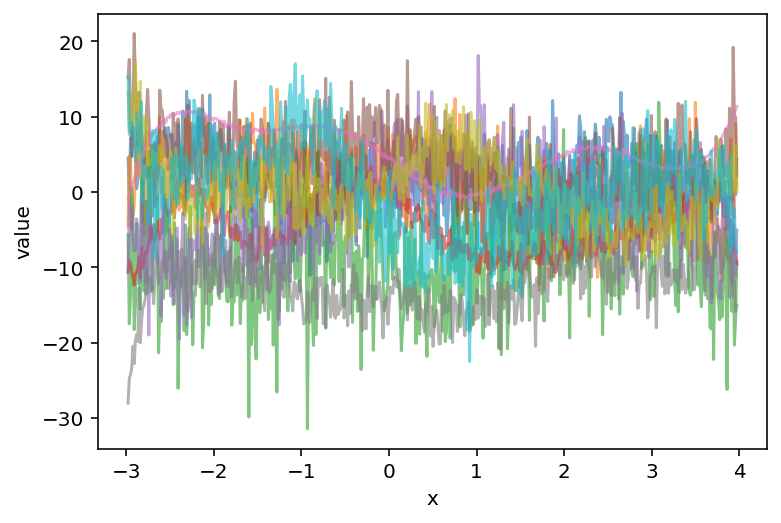

In [ ]:
_plot_prior(m1_prior_pred, "y", data=new_single_curve_data.data, alpha=0.6)

### Sample from posterior

In [106]:
pm_sample_kwargs = {
    "draws": 500,
    "tune": 200,
    "chains": 2,
    "cores": 2,
    "target_accept": 0.95,
    "return_inferencedata": True,
}
pm_ppc_kwargs = {"extend_inferencedata": True, "progressbar": False}

In [107]:
with build_model1(single_curve_data):
    m1_trace = pm.sample(**pm_sample_kwargs)
    pm.sample_posterior_predictive(m1_trace, **pm_ppc_kwargs)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, w, sigma]


Sampling 2 chains for 200 tune and 500 draw iterations (400 + 1_000 draws total) took 25 seconds.
The number of effective samples is smaller than 25% for some parameters.


### Posterior analysis

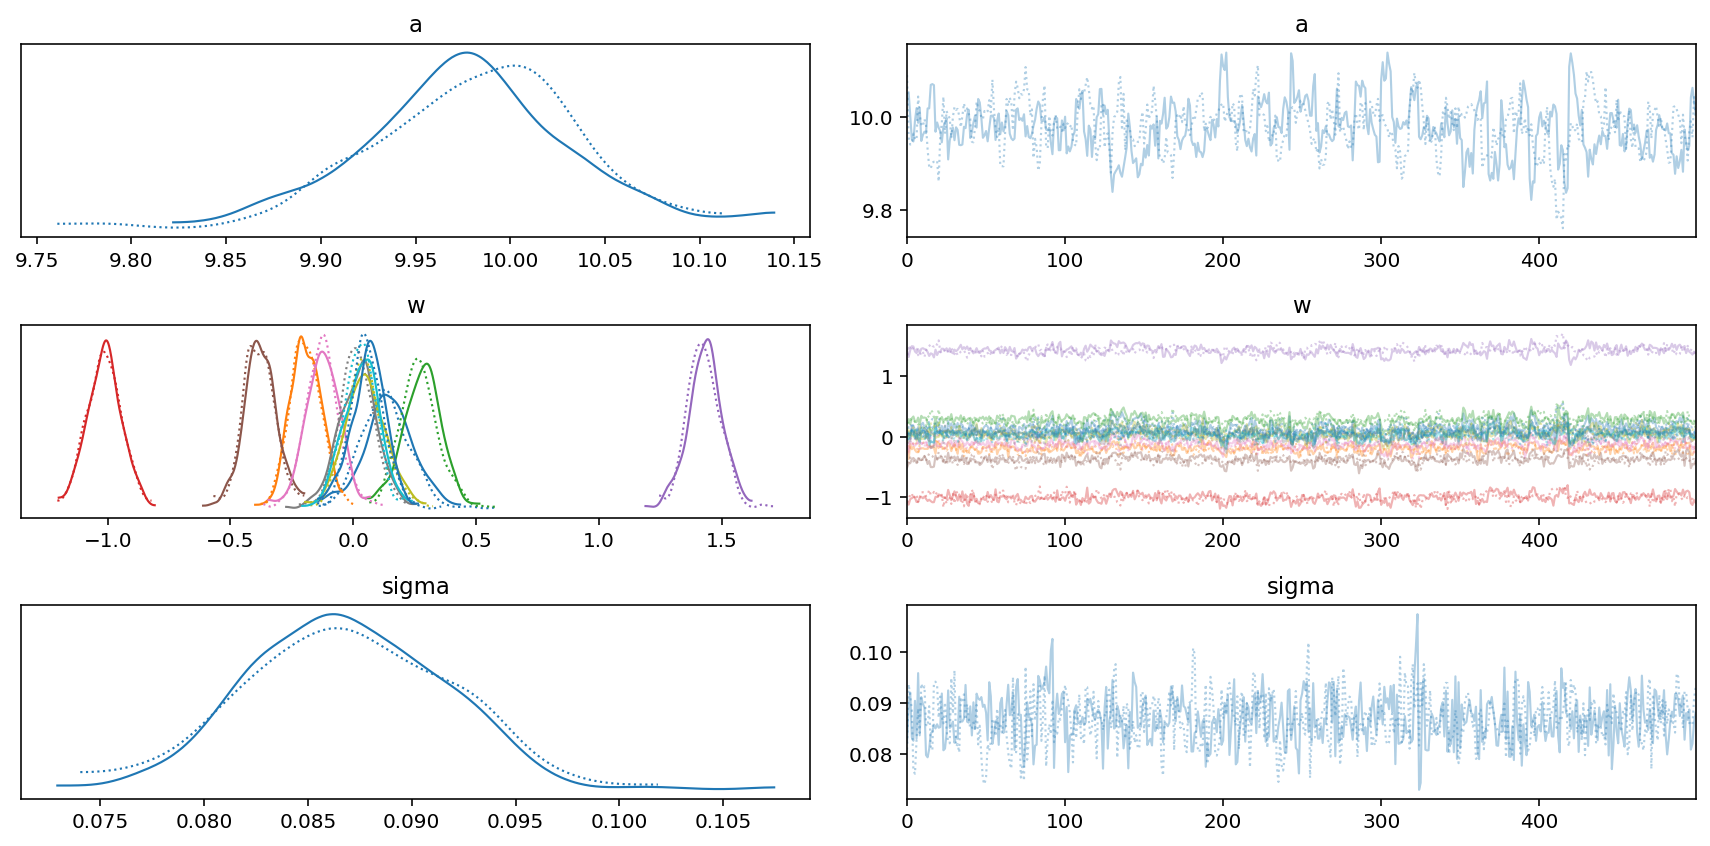

In [108]:
az.plot_trace(m1_trace, var_names=["~mu"])
plt.tight_layout();

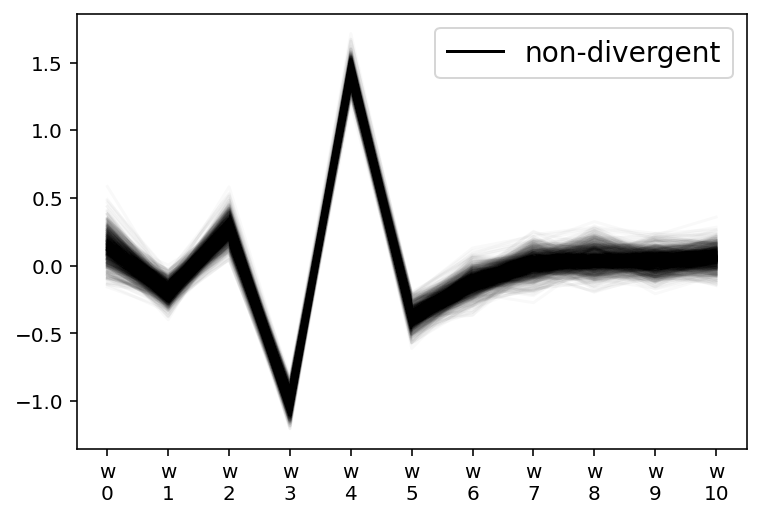

In [109]:
az.plot_parallel(m1_trace, var_names=["w"]);

In [110]:
az.summary(m1_trace, var_names=["~mu"])

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
a      9.980  0.054   9.877   10.080      0.004    0.003     206.0     248.0   
w[0]   0.138  0.102  -0.047    0.344      0.006    0.005     251.0     352.0   
w[1]  -0.194  0.063  -0.309   -0.077      0.003    0.002     372.0     412.0   
w[2]   0.274  0.080   0.127    0.425      0.005    0.003     287.0     483.0   
w[3]  -1.014  0.069  -1.140   -0.878      0.004    0.003     307.0     444.0   
w[4]   1.431  0.069   1.299    1.555      0.005    0.003     241.0     287.0   
w[5]  -0.381  0.067  -0.508   -0.251      0.004    0.003     277.0     261.0   
w[6]  -0.125  0.071  -0.252    0.011      0.004    0.003     271.0     397.0   
w[7]   0.016  0.075  -0.128    0.159      0.004    0.003     355.0     294.0   
w[8]   0.049  0.081  -0.105    0.203      0.005    0.004     288.0     405.0   
w[9]   0.031  0.070  -0.105    0.154      0.004    0.003     332.0     378.0   
w[10]  0.060  0.069  -0.075    0.186      0.004    0.003     272.0     253.0   
sigma  0.087  0.005   0.079    0.096      0.000    0.000     697.0     674.0   

       r_hat  
a       1.01  
w[0]    1.01  
w[1]    1.00  
w[2]    1.01  
w[3]    1.00  
w[4]    1.01  
w[5]    1.01  
w[6]    1.00  
w[7]    1.01  
w[8]    1.00  
w[9]    1.00  
w[10]   1.01  
sigma   1.00

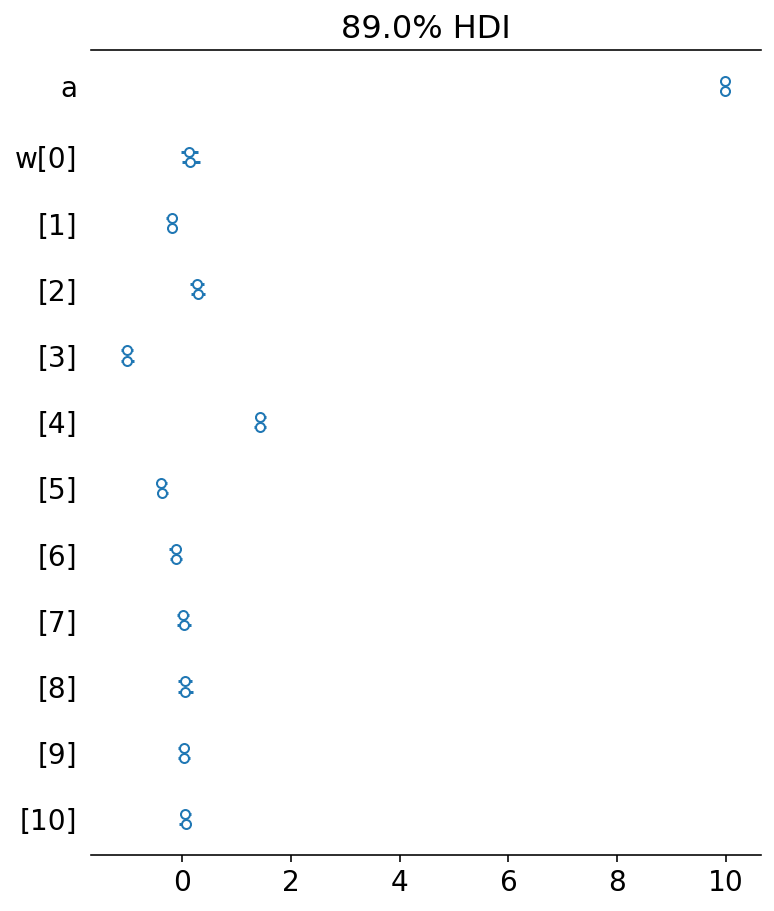

In [111]:
az.plot_forest(m1_trace, var_names=["a", "w"], hdi_prob=HDI_PROB);

In [112]:
def _plot_posterior_mu(
    trace: az.InferenceData, data: pd.DataFrame, pt_alpha: float = 0.5
) -> gg.ggplot:
    mu_post_df = (
        az.summary(trace, var_names="mu", hdi_prob=HDI_PROB, kind="stats")
        .reset_index(drop=True)
        .merge(data.copy(), left_index=True, right_index=True)
    )

    if "k" not in data.columns:
        mu_post_df["k"] = "a"

    return (
        gg.ggplot(mu_post_df, gg.aes(x="x"))
        + gg.geom_point(gg.aes(y="y", color="k"), alpha=pt_alpha)
        + gg.geom_ribbon(gg.aes(ymin="hdi_5.5%", ymax="hdi_94.5%", fill="k"), alpha=0.5)
        + gg.geom_line(gg.aes(y="mean", color="k"), size=0.5)
        + gg.scale_color_manual(group_pal)
        + gg.scale_fill_manual(group_pal)
    )

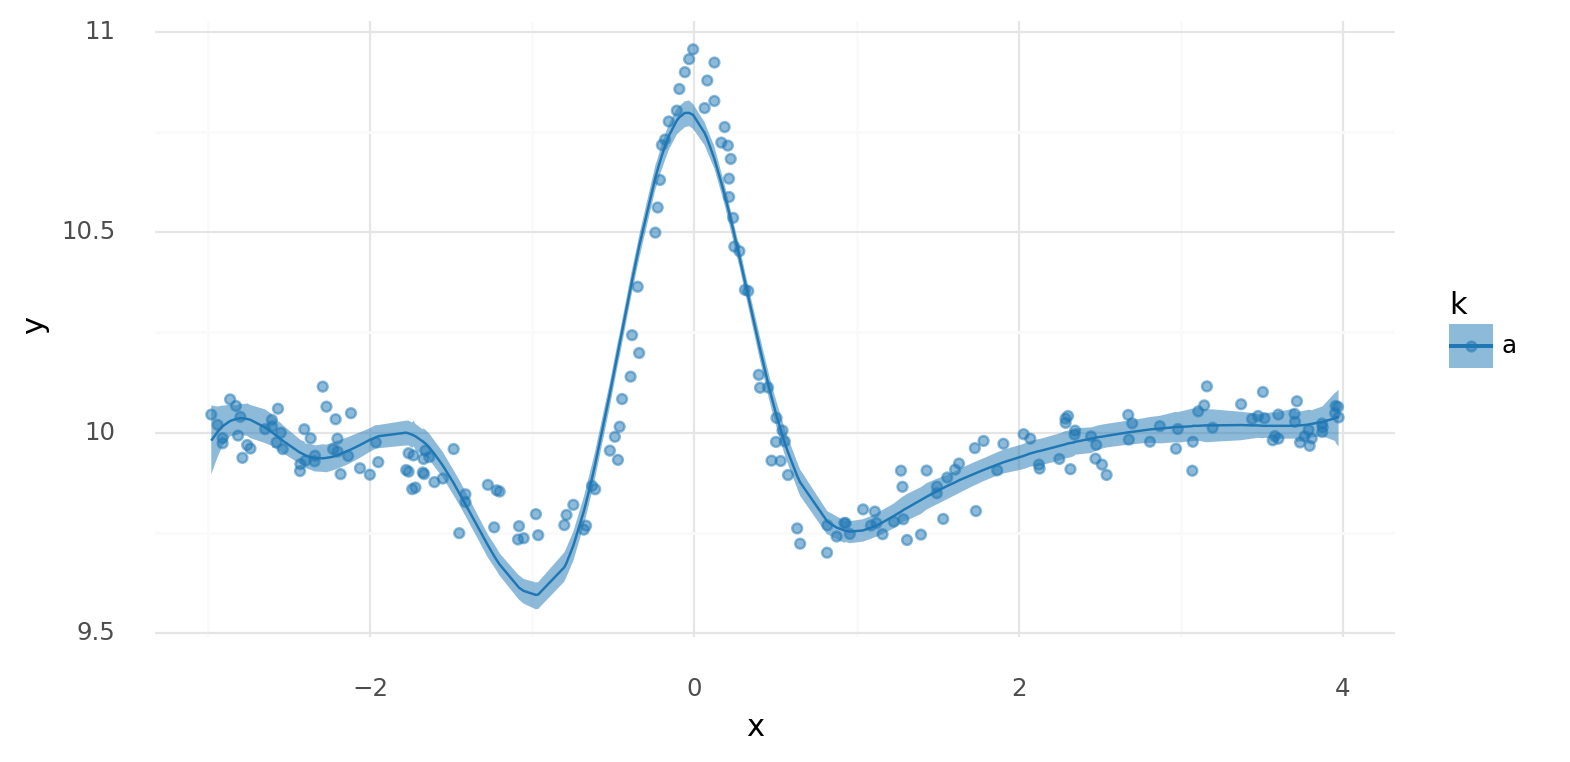

<ggplot: (349697735)>

In [113]:
_plot_posterior_mu(m1_trace, data=single_curve_data.data)

In [114]:
def _plot_ppc(
    trace: az.InferenceData, data: pd.DataFrame, pt_alpha: float = 0.5
) -> gg.ggplot:
    post_pred = trace.posterior_predictive["y"].values.reshape(-1, data.shape[0])
    ppc_avg = post_pred.mean(0)
    ppc_hdi = az.hdi(post_pred, hdi_prob=HDI_PROB)

    plot_df = data.copy().assign(
        post_pred=ppc_avg, hdi_low=ppc_hdi[:, 0], hdi_high=ppc_hdi[:, 1]
    )

    if "k" not in data.columns:
        plot_df["k"] = np.repeat(["a"], plot_df.shape[0])

    return (
        gg.ggplot(plot_df, gg.aes(x="x"))
        + gg.geom_point(gg.aes(y="y", color="k"), alpha=pt_alpha)
        + gg.geom_ribbon(gg.aes(ymin="hdi_low", ymax="hdi_high", fill="k"), alpha=0.5)
        + gg.geom_line(gg.aes(y="post_pred", color="k"), size=1)
        + gg.scale_color_manual(group_pal)
        + gg.scale_fill_manual(group_pal)
    )

/var/folders/r4/qpcdgl_14hbd412snp1jnv300000gn/T/ipykernel_15931/2876986528.py:6: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions


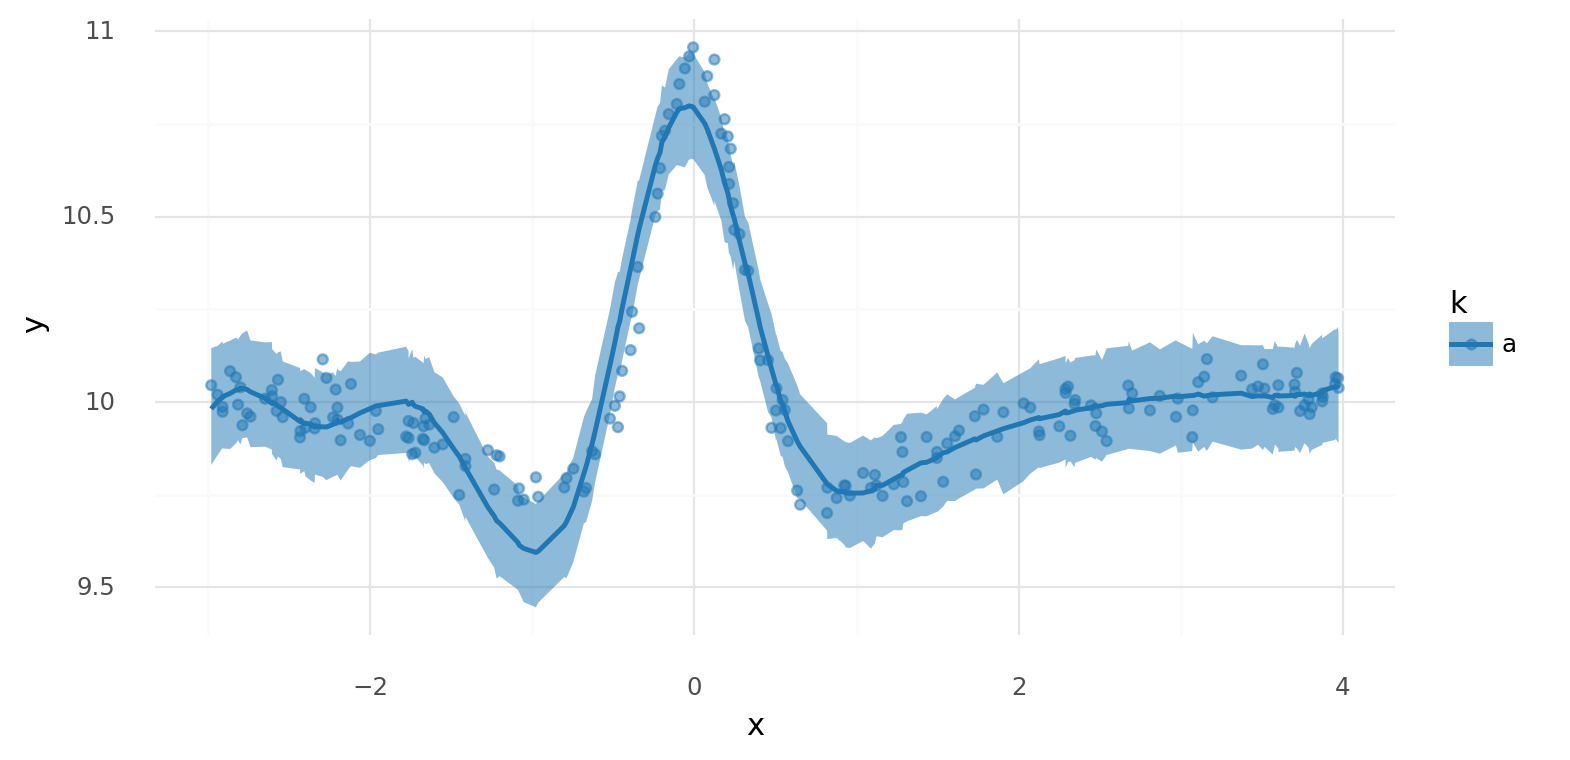

<ggplot: (350753642)>

In [115]:
_plot_ppc(m1_trace, single_curve_data.data)

## Two groups: single set of weights

### Data

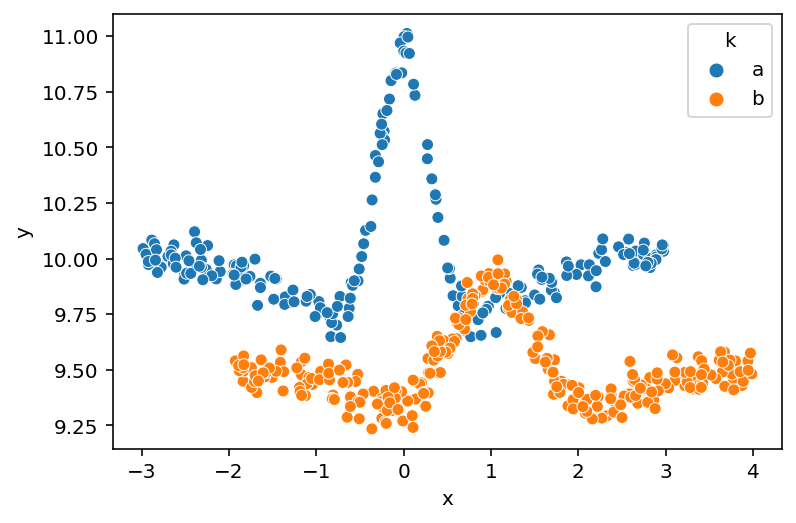

In [116]:
np.random.seed(RANDOM_SEED)

_x1 = np.random.uniform(-3, 3, 200)
_d1 = diff_of_gaussians(_x1, (0, 0), (0.3, 1), 0.05, y_offset=10).assign(k="a")
_x2 = np.random.uniform(-3, 3, 300) + 1
_d2 = diff_of_gaussians(_x2, (1, 1), (0.5, 1), 0.05, y_offset=9.5).assign(k="b")

_data = pd.concat([_d1, _d2]).reset_index(drop=True)
_data["k"] = pd.Categorical(_data["k"], categories=["a", "b"], ordered=True)

sns.scatterplot(data=_data, x="x", y="y", hue="k", palette=group_pal);

### Spline basis

In [117]:
_knots, _B = _build_spline(_data)
two_spline_data = ModelData(data=_data.copy(), B=_B, knots=_knots)

### Sample from posterior

In [118]:
with build_model1(two_spline_data):
    m1_trace2 = pm.sample(**pm_sample_kwargs)
    pm.sample_posterior_predictive(m1_trace2, **pm_ppc_kwargs)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, w, sigma]


Sampling 2 chains for 200 tune and 500 draw iterations (400 + 1_000 draws total) took 22 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.


### Posterior analysis

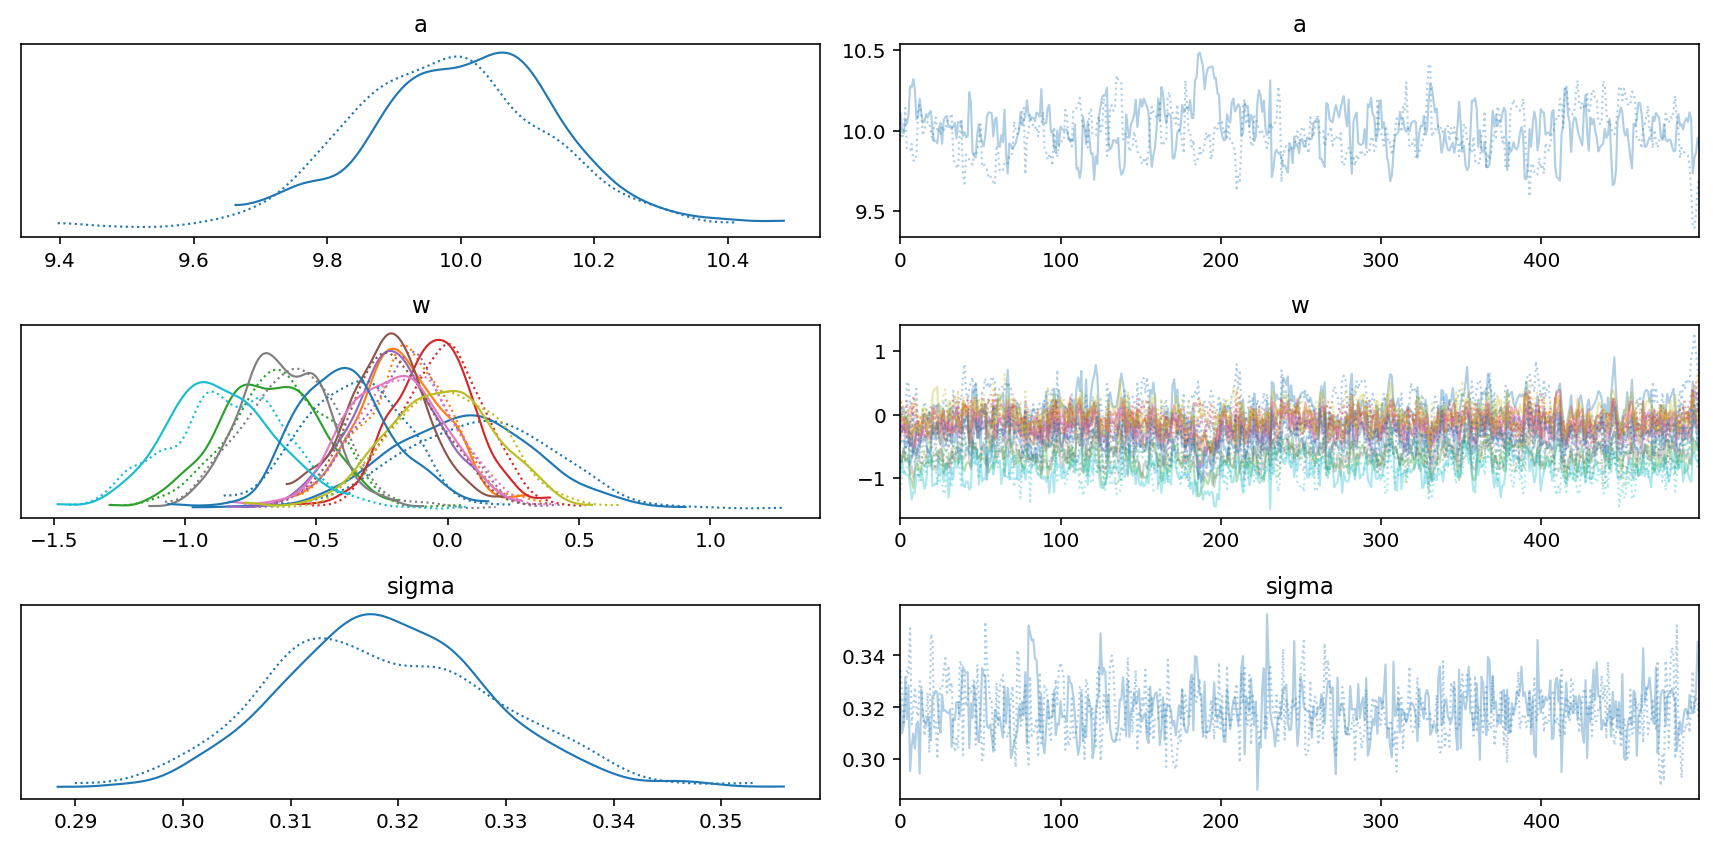

In [119]:
az.plot_trace(m1_trace2, var_names=["~mu"])
plt.tight_layout();

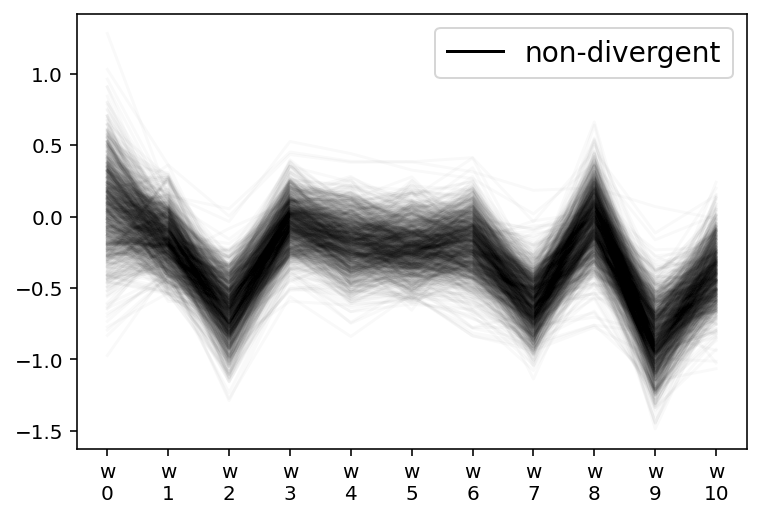

In [120]:
az.plot_parallel(m1_trace2, var_names=["w"]);

In [121]:
az.summary(m1_trace2, var_names=["~mu"], filter_vars="regex")

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
a      9.995  0.146   9.730   10.275      0.015    0.011      99.0     188.0   
w[0]   0.084  0.287  -0.446    0.592      0.026    0.018     123.0     213.0   
w[1]  -0.161  0.169  -0.505    0.126      0.010    0.008     260.0     421.0   
w[2]  -0.662  0.194  -1.035   -0.330      0.017    0.013     125.0     275.0   
w[3]  -0.038  0.161  -0.321    0.259      0.013    0.009     157.0     233.0   
w[4]  -0.182  0.179  -0.532    0.136      0.017    0.012     116.0     227.0   
w[5]  -0.212  0.166  -0.533    0.101      0.014    0.010     147.0     201.0   
w[6]  -0.186  0.191  -0.524    0.176      0.016    0.012     158.0     206.0   
w[7]  -0.611  0.175  -0.937   -0.299      0.014    0.010     146.0     365.0   
w[8]  -0.018  0.212  -0.389    0.371      0.014    0.010     241.0     415.0   
w[9]  -0.852  0.216  -1.250   -0.471      0.014    0.010     220.0     256.0   
w[10] -0.376  0.192  -0.719   -0.024      0.015    0.011     173.0     355.0   
sigma  0.319  0.010   0.300    0.338      0.000    0.000     672.0     552.0   

       r_hat  
a       1.02  
w[0]    1.02  
w[1]    1.01  
w[2]    1.02  
w[3]    1.01  
w[4]    1.02  
w[5]    1.01  
w[6]    1.01  
w[7]    1.02  
w[8]    1.00  
w[9]    1.01  
w[10]   1.01  
sigma   1.01

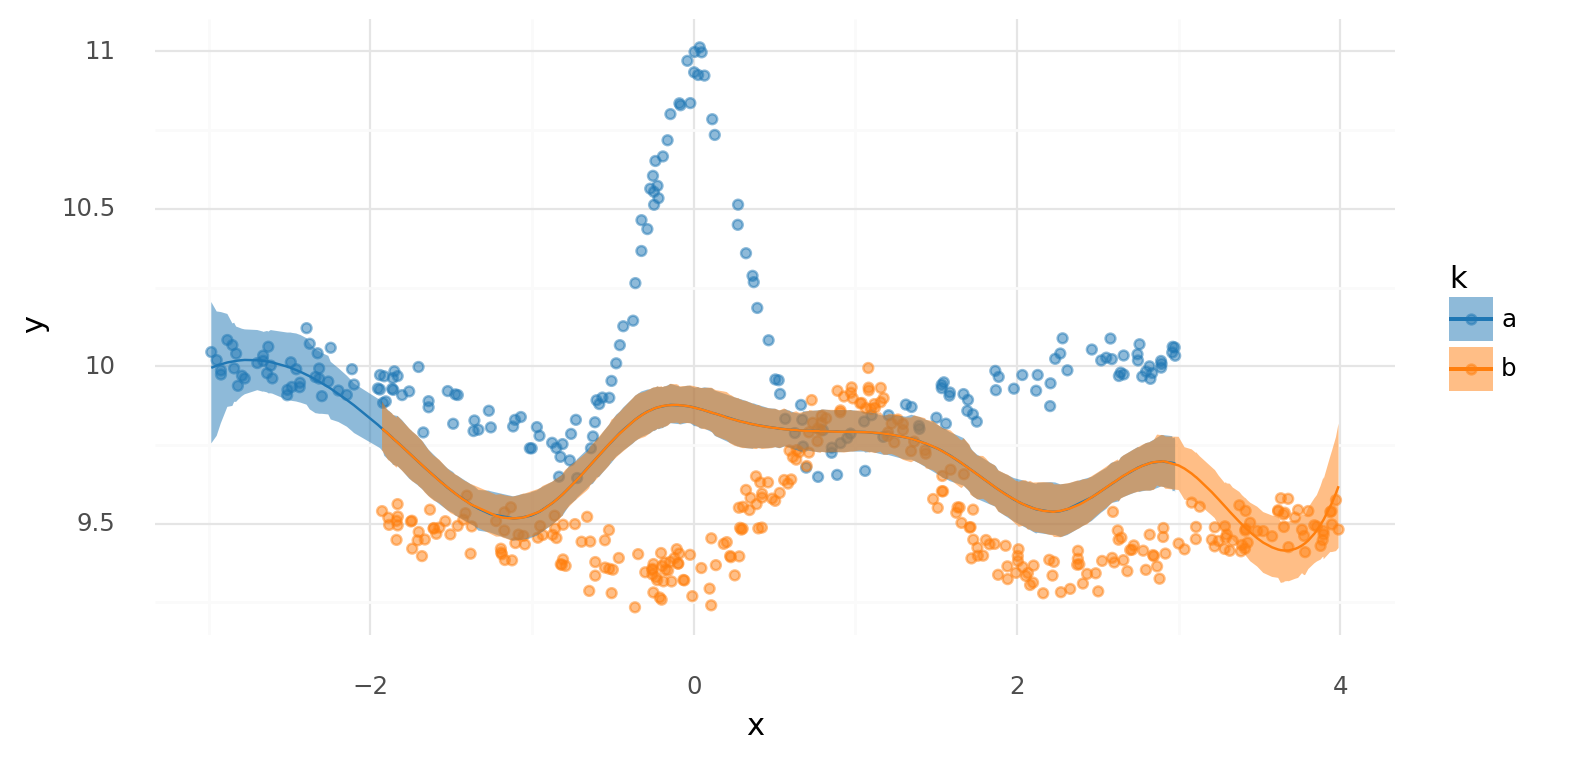

<ggplot: (350177988)>

In [122]:
_plot_posterior_mu(m1_trace2, data=two_spline_data.data)

/var/folders/r4/qpcdgl_14hbd412snp1jnv300000gn/T/ipykernel_15931/2876986528.py:6: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions


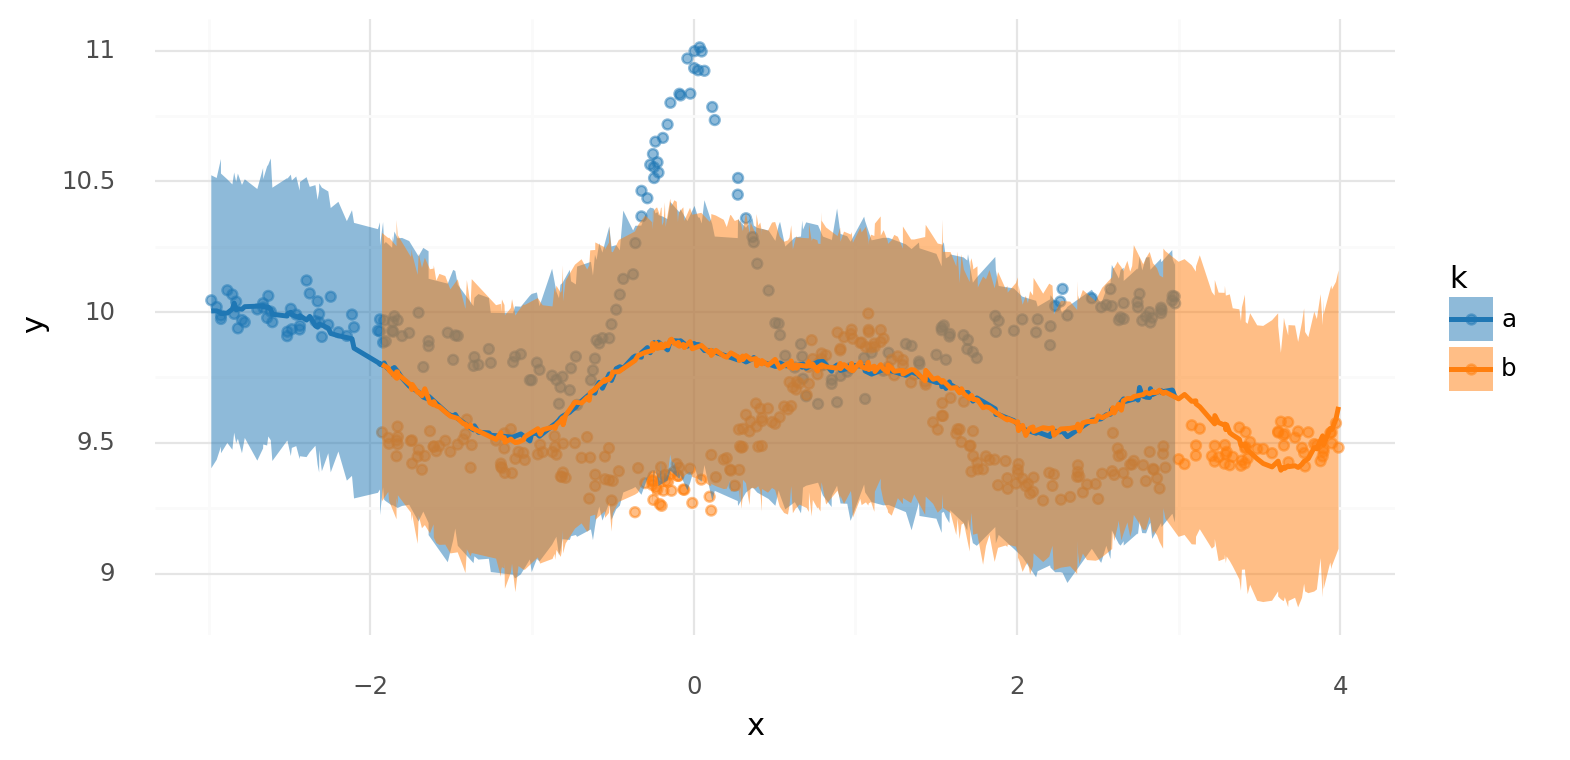

<ggplot: (350176064)>

In [123]:
_plot_ppc(m1_trace2, two_spline_data.data)

## Two groups: separate spline bases and per-group weights

### Spline basis

In [280]:
_knots = _make_knot_list(two_spline_data.data)
multi_model_data: list[ModelData] = []
for k in two_spline_data.data.k.unique():
    data_k = two_spline_data.data.copy().query(f"k=='{k}'").reset_index(drop=True)
    _, B_k = _build_spline(data_k, knot_list=_knots)
    _md = ModelData(data=data_k, B=B_k, knots=_knots)
    multi_model_data.append(_md)

print(len(multi_model_data))

[-2.98362837 -1.83026171 -0.96462691 -0.26474952  0.22878958  0.7907478
  1.54079139  2.26772779  2.96112309  3.98828591]
[-2.98362837 -1.83026171 -0.96462691 -0.26474952  0.22878958  0.7907478
  1.54079139  2.26772779  2.96112309  3.98828591]
2


In [125]:
for md in multi_model_data:
    print(md.B.shape)

(200, 11)
(300, 11)


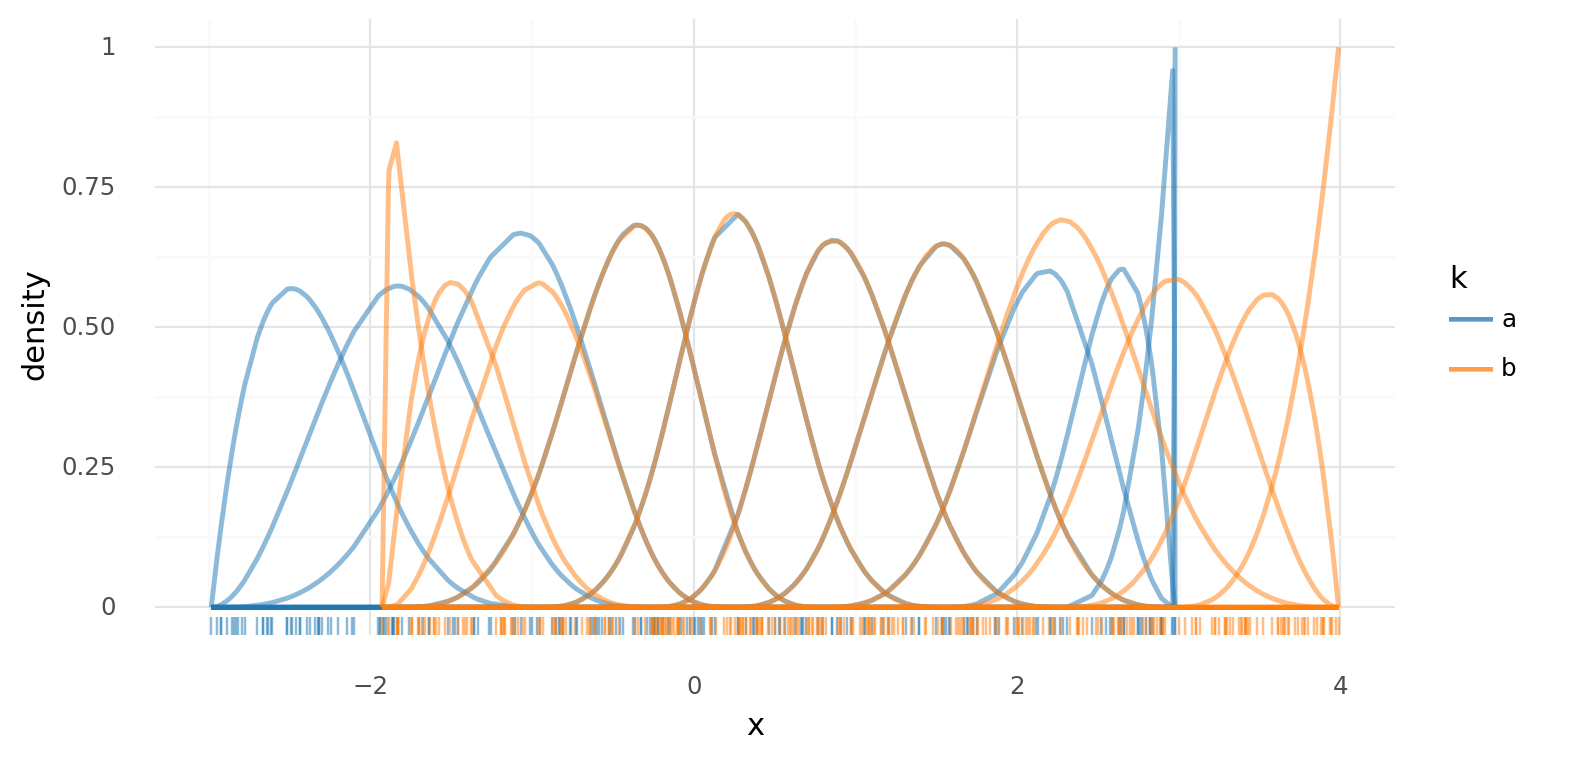

<ggplot: (351544399)>

In [126]:
def _stack_splines(datas: list[ModelData]) -> np.ndarray:
    return np.vstack([np.asarray(md.B) for md in datas])


def _stack_data(datas: list[ModelData]) -> pd.DataFrame:
    return pd.concat([md.data for md in datas]).reset_index(drop=True)


_stacked_B = _stack_splines(multi_model_data)
_stacked_data = _stack_data(multi_model_data)

basis_df = (
    pd.DataFrame(_stacked_B)
    .assign(k=_stacked_data.k.values, x=_stacked_data.x.values)
    .pivot_longer(["k", "x"], names_to="basis", values_to="density")
    .assign(basis=lambda d: [f"{k}: {x}" for x, k in zip(d.basis, d.k)])
)
(
    gg.ggplot(basis_df, gg.aes(x="x", color="k"))
    + gg.geom_line(gg.aes(group="basis", y="density"), alpha=0.5, size=1)
    + gg.geom_rug(data=_stacked_data, alpha=0.5, sides="b")
    + gg.scale_color_manual(values=group_pal)
)

### Model #2

Fits well, but cannot make predictions on out-of-distribution values of $x$ for each group.

In [171]:
def build_model2(datas: list[ModelData]) -> pm.Model:
    B_dim = datas[0].B.shape[1]
    for md in datas:
        assert md.B.shape[1] == B_dim, "Splines have different number of features."

    B_k = [np.asarray(md.B) for md in datas]
    df = _stack_data(datas)
    k = df.k.cat.codes.values.astype(int)
    n_k = len(df.k.cat.categories)

    with pm.Model(rng_seeder=RANDOM_SEED) as m2:
        a = pm.Normal("a", 0, 5, shape=n_k)
        w = pm.Normal("w", 0, 2, shape=(B_dim, n_k))
        _mu = []
        for i in range(n_k):
            _mu.append(pmmath.dot(B_k[i], w[:, i]).reshape((-1, 1)))
        mu = pm.Deterministic("mu", a[k] + at.vertical_stack(*_mu).squeeze())
        sigma = pm.Gamma("sigma", 2, 0.5)
        y = pm.Normal("y", mu, sigma, observed=df.y.values)
    return m2

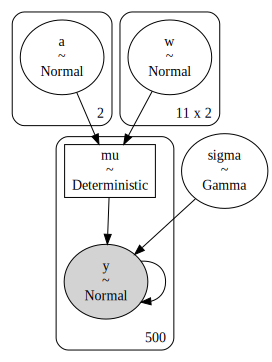

In [172]:
m2 = build_model2(multi_model_data)
pm.model_to_graphviz(m2)

### Sample from posterior

In [173]:
with build_model2(multi_model_data):
    m2_trace = pm.sample(**pm_sample_kwargs)
    pm.sample_posterior_predictive(m2_trace, **pm_ppc_kwargs)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, w, sigma]


Sampling 2 chains for 200 tune and 500 draw iterations (400 + 1_000 draws total) took 47 seconds.
The number of effective samples is smaller than 25% for some parameters.


### Posterior analysis

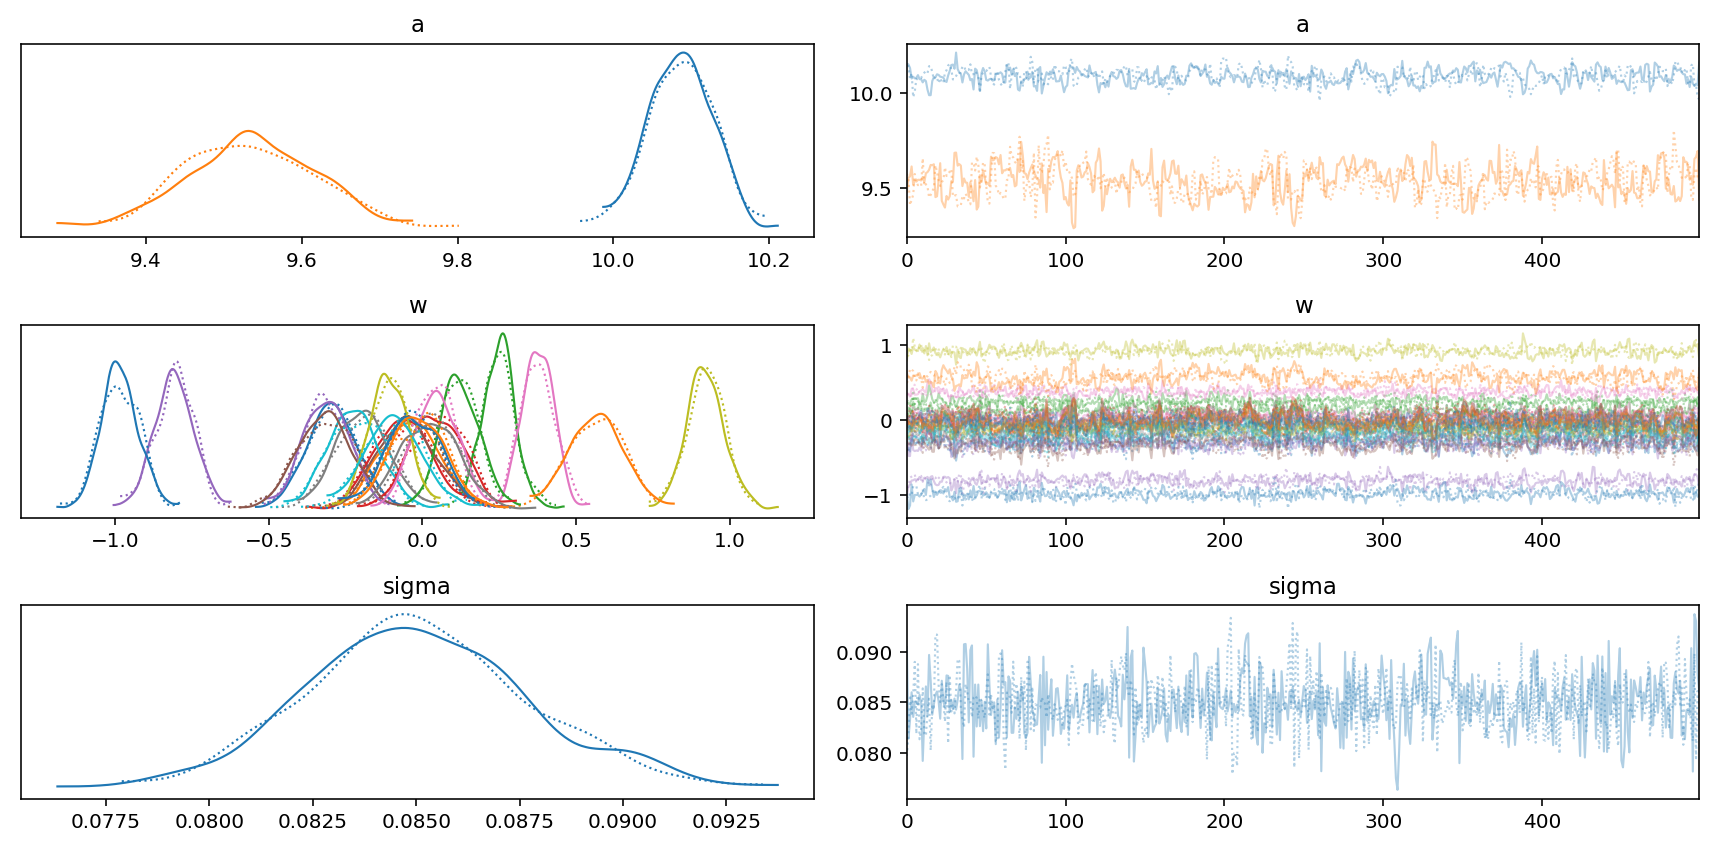

In [174]:
az.plot_trace(m2_trace, var_names=["~mu"])
plt.tight_layout();

In [175]:
az.summary(m2_trace, var_names=["~mu"], hdi_prob=HDI_PROB)

mean     sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  ess_bulk  \
a[0]      10.086  0.040    10.027     10.153      0.002    0.001     366.0   
a[1]       9.536  0.081     9.419      9.672      0.005    0.004     245.0   
w[0, 0]   -0.294  0.081    -0.435     -0.174      0.004    0.003     406.0   
w[0, 1]   -0.037  0.095    -0.177      0.120      0.006    0.004     295.0   
w[1, 0]    0.248  0.055     0.150      0.324      0.002    0.001     684.0   
w[1, 1]   -0.061  0.094    -0.198      0.100      0.005    0.004     322.0   
w[2, 0]   -0.807  0.063    -0.907     -0.712      0.003    0.002     496.0   
w[2, 1]   -0.047  0.094    -0.195      0.102      0.005    0.004     318.0   
w[3, 0]    0.376  0.053     0.293      0.462      0.002    0.002     536.0   
w[3, 1]   -0.194  0.085    -0.329     -0.057      0.005    0.004     282.0   
w[4, 0]    0.921  0.061     0.823      1.018      0.003    0.002     539.0   
w[4, 1]   -0.222  0.087    -0.355     -0.092      0.005    0.004     260.0   
w[5, 0]   -0.984  0.063    -1.074     -0.883      0.003    0.002     515.0   
w[5, 1]    0.564  0.088     0.427      0.700      0.005    0.004     272.0   
w[6, 0]    0.120  0.063     0.028      0.224      0.003    0.002     521.0   
w[6, 1]    0.050  0.088    -0.079      0.186      0.005    0.004     270.0   
w[7, 0]   -0.313  0.074    -0.421     -0.190      0.003    0.002     583.0   
w[7, 1]   -0.318  0.090    -0.447     -0.171      0.005    0.004     282.0   
w[8, 0]    0.042  0.067    -0.056      0.153      0.003    0.002     584.0   
w[8, 1]    0.026  0.090    -0.122      0.162      0.005    0.004     310.0   
w[9, 0]   -0.110  0.063    -0.215     -0.020      0.003    0.002     561.0   
w[9, 1]   -0.092  0.094    -0.246      0.052      0.006    0.004     262.0   
w[10, 0]  -0.032  0.086    -0.163      0.103      0.003    0.002     602.0   
w[10, 1]  -0.014  0.089    -0.159      0.118      0.005    0.004     281.0   
sigma      0.085  0.003     0.081      0.090      0.000    0.000     962.0   

          ess_tail  r_hat  
a[0]         520.0   1.01  
a[1]         386.0   1.00  
w[0, 0]      669.0   1.00  
w[0, 1]      437.0   1.00  
w[1, 0]      494.0   1.00  
w[1, 1]      542.0   1.00  
w[2, 0]      639.0   1.00  
w[2, 1]      607.0   1.00  
w[3, 0]      592.0   1.00  
w[3, 1]      584.0   1.00  
w[4, 0]      657.0   1.00  
w[4, 1]      404.0   1.00  
w[5, 0]      580.0   1.00  
w[5, 1]      434.0   1.00  
w[6, 0]      675.0   1.00  
w[6, 1]      483.0   1.00  
w[7, 0]      701.0   1.00  
w[7, 1]      498.0   1.00  
w[8, 0]      541.0   1.01  
w[8, 1]      476.0   1.00  
w[9, 0]      662.0   1.00  
w[9, 1]      690.0   1.00  
w[10, 0]     624.0   1.00  
w[10, 1]     509.0   1.00  
sigma        559.0   1.00

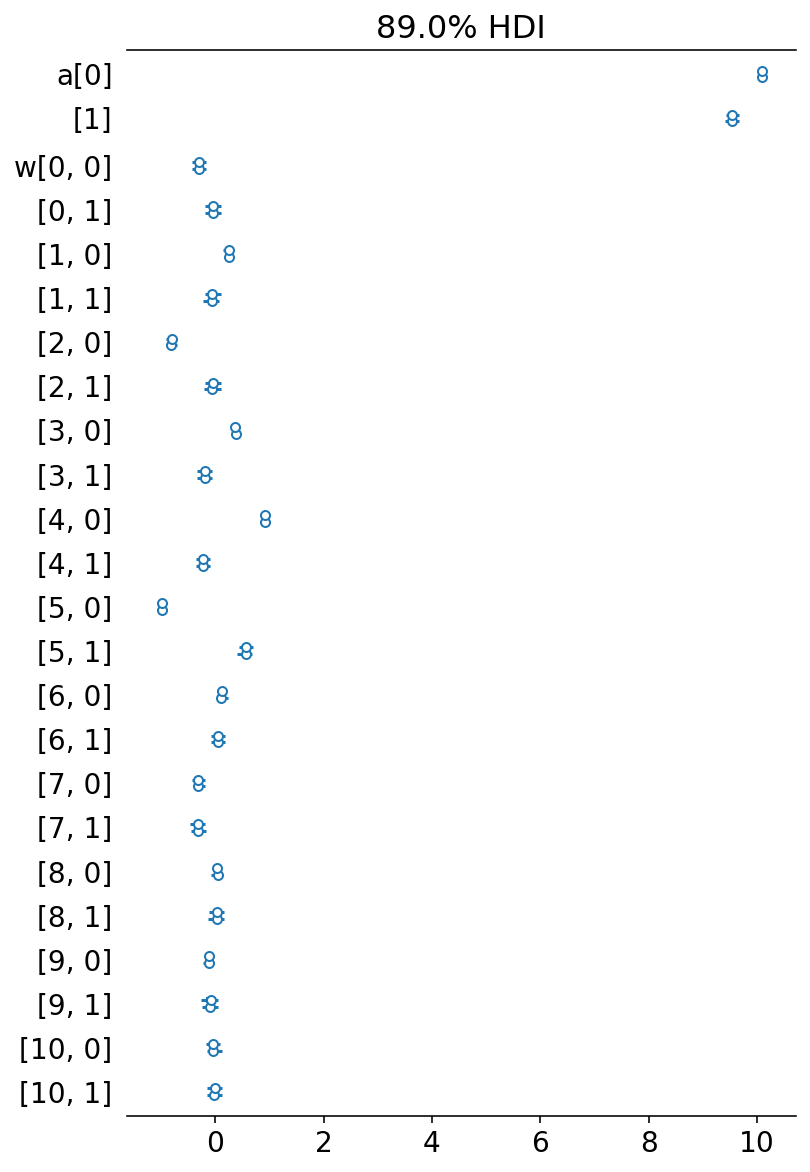

In [176]:
az.plot_forest(m2_trace, var_names=["a", "w"], hdi_prob=HDI_PROB);

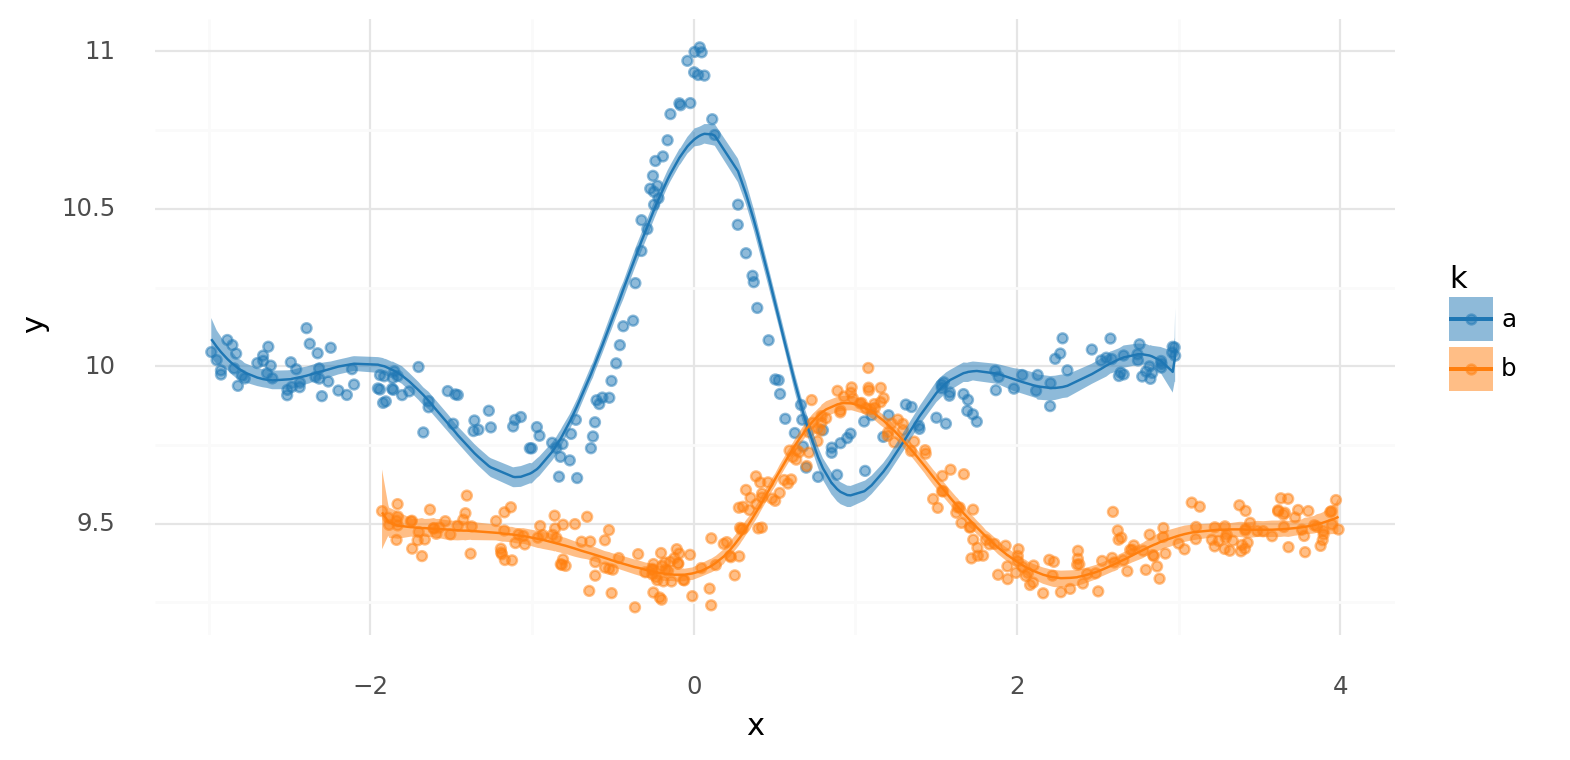

<ggplot: (355439318)>

In [177]:
_plot_posterior_mu(m2_trace, data=_stacked_data)

/var/folders/r4/qpcdgl_14hbd412snp1jnv300000gn/T/ipykernel_15931/2876986528.py:6: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions


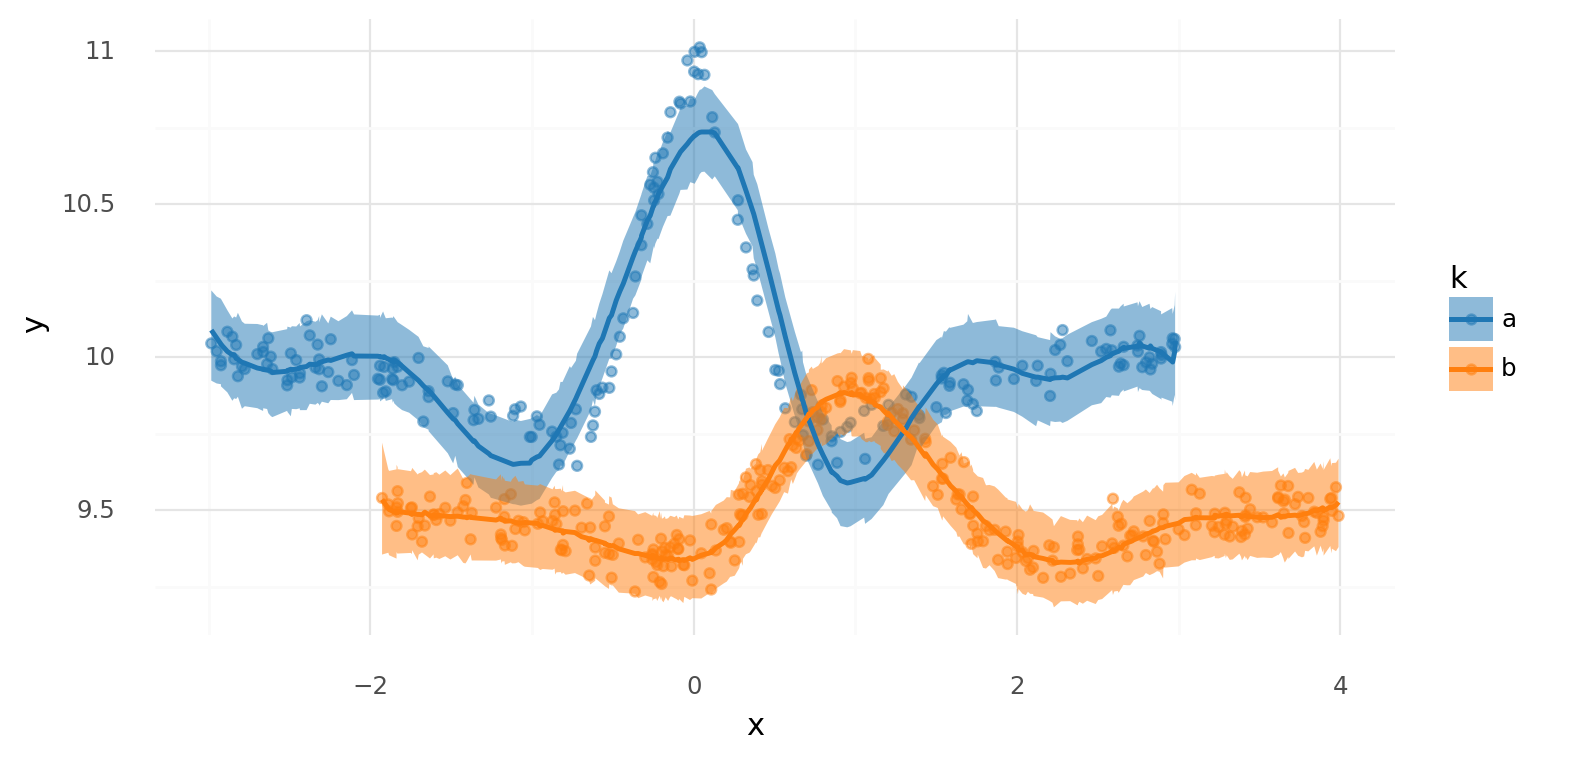

<ggplot: (355415869)>

In [178]:
_plot_ppc(m2_trace, _stacked_data)

## Two groups: single spline basis and per-group weights

### Spline bases

In [382]:
_df = two_spline_data.data.copy().reset_index(drop=True)
_knots, _joint_B = _build_spline(_df, intercept=True)
m3_data = ModelData(data=_df, B=_joint_B, knots=_knots)

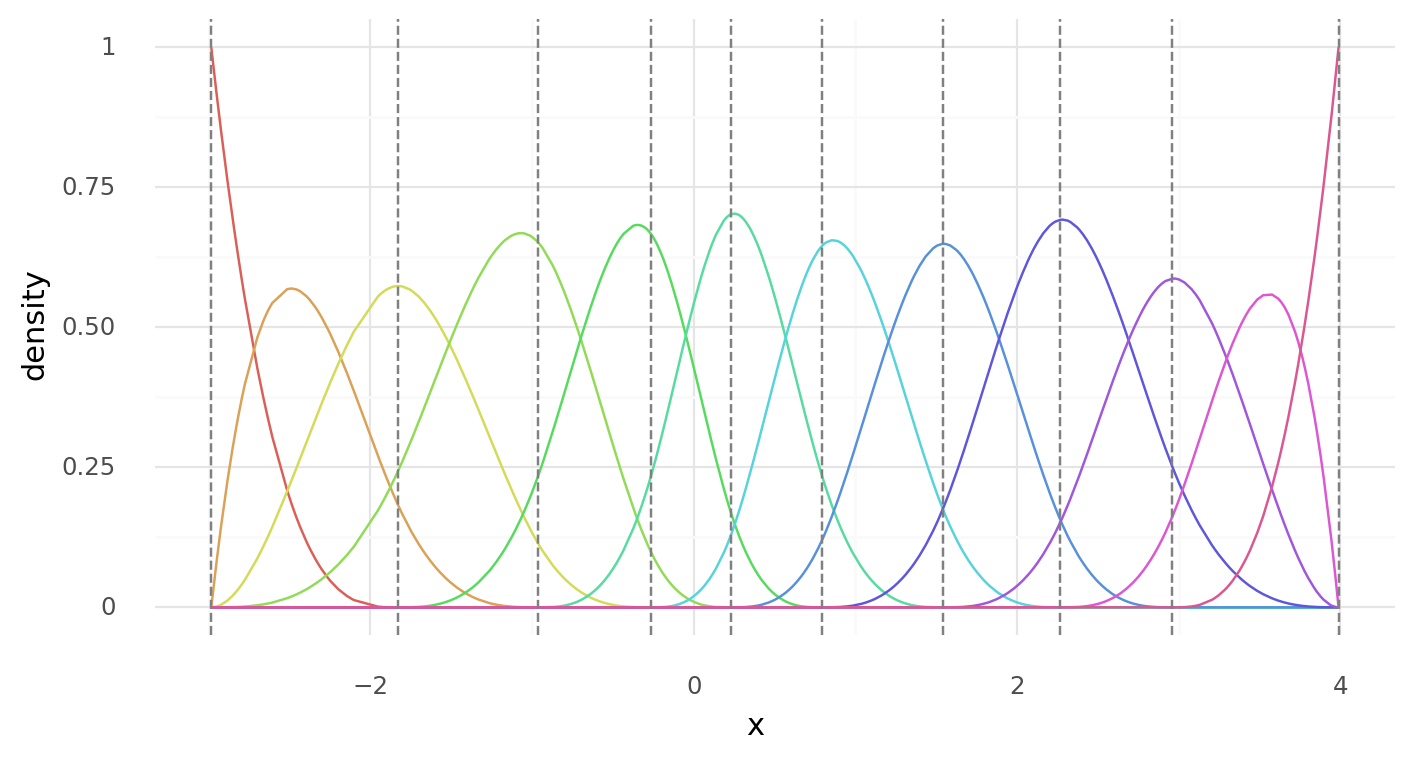

<ggplot: (350629651)>

In [383]:
_plot_spline_basis(m3_data)

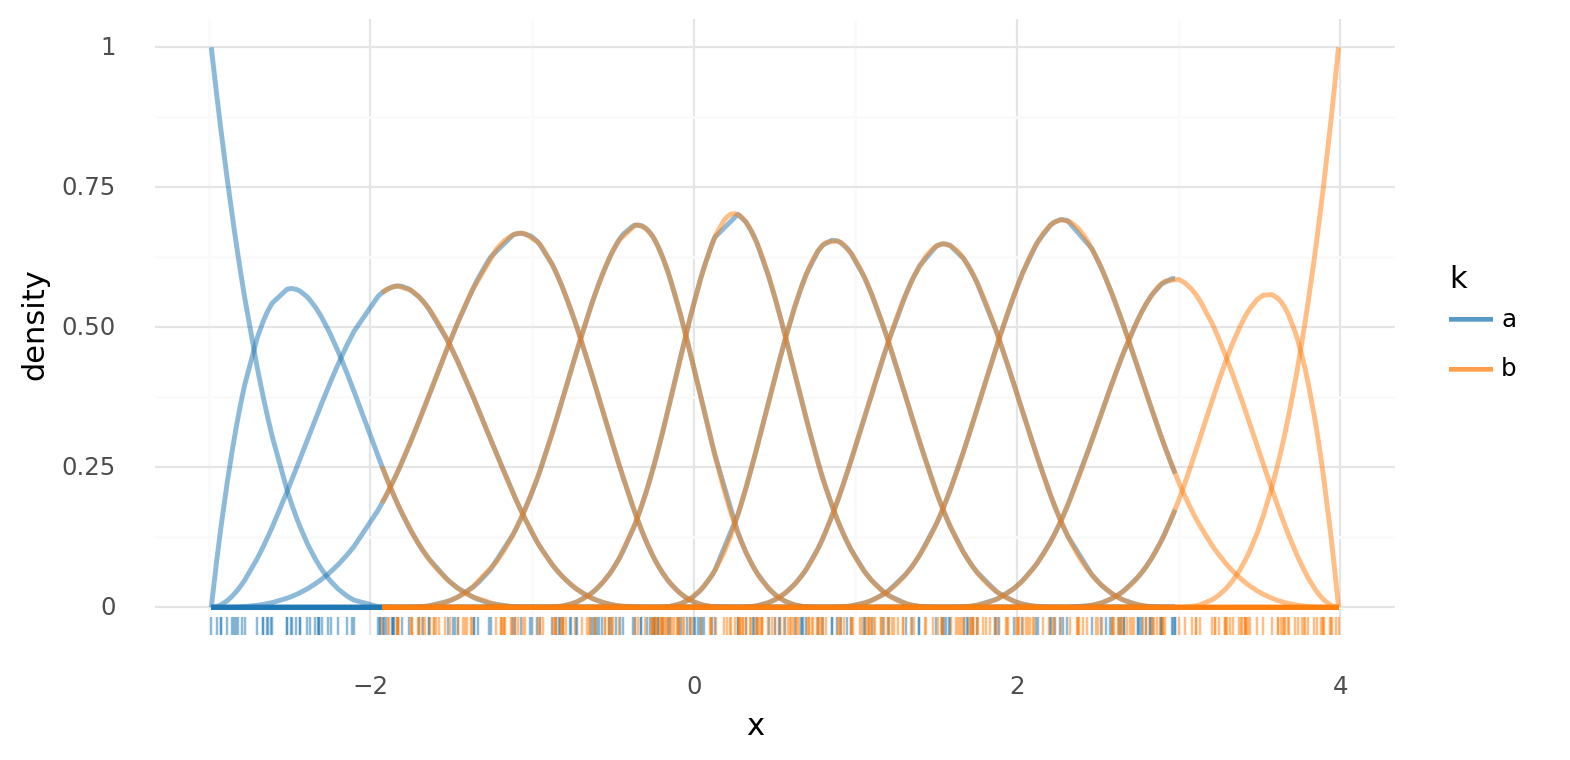

<ggplot: (354015281)>

In [384]:
basis_df = (
    pd.DataFrame(m3_data.B)
    .assign(k=m3_data.data.k.values, x=m3_data.data.x.values)
    .pivot_longer(["k", "x"], names_to="basis", values_to="density")
    .assign(basis=lambda d: [f"{k}: {x}" for x, k in zip(d.basis, d.k)])
)
(
    gg.ggplot(basis_df, gg.aes(x="x", color="k"))
    + gg.geom_line(gg.aes(group="basis", y="density"), alpha=0.5, size=1)
    + gg.geom_rug(data=m3_data.data, alpha=0.5, sides="b")
    + gg.scale_color_manual(values=group_pal)
)

### Model #3

Include an intercept in the spline basis that will be the per-group varying intercept.
Then add only a single global intercept $a$ in the model.

Does not fit as easily as with separate spline bases, but can make predictions on out-of-distribution $x$ for each group, but still within the full spline basis.

In [406]:
def build_model3(model_data: ModelData) -> pm.Model:
    B, df = np.asarray(model_data.B), model_data.data
    B_dim = B.shape[1]
    k = df.k.cat.codes.values.astype(int)
    n_k = len(df.k.cat.categories)
    with pm.Model(rng_seeder=RANDOM_SEED) as m3:
        a = pm.Normal("a", 0, 5)
        w = pm.Normal("w", 0, 2, shape=(B_dim, n_k))
        _mu = []
        for i in range(n_k):
            _mu.append(at.dot(B[k == i, :], w[:, i]).reshape((-1, 1)))
        mu = pm.Deterministic("mu", a + at.vertical_stack(*_mu).squeeze())
        sigma = pm.Gamma("sigma", 2, 0.5)
        y = pm.Normal("y", mu, sigma, observed=df.y.values)
    return m3

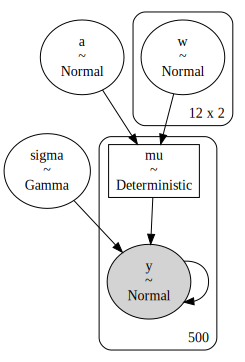

In [407]:
m3 = build_model3(m3_data)
pm.model_to_graphviz(m3)

### Sample from posterior

In [408]:
with build_model3(m3_data):
    m3_trace = pm.sample(**pm_sample_kwargs)
    pm.sample_posterior_predictive(m3_trace, **pm_ppc_kwargs)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, w, sigma]


Sampling 2 chains for 200 tune and 500 draw iterations (400 + 1_000 draws total) took 93 seconds.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.


### Posterior analysis

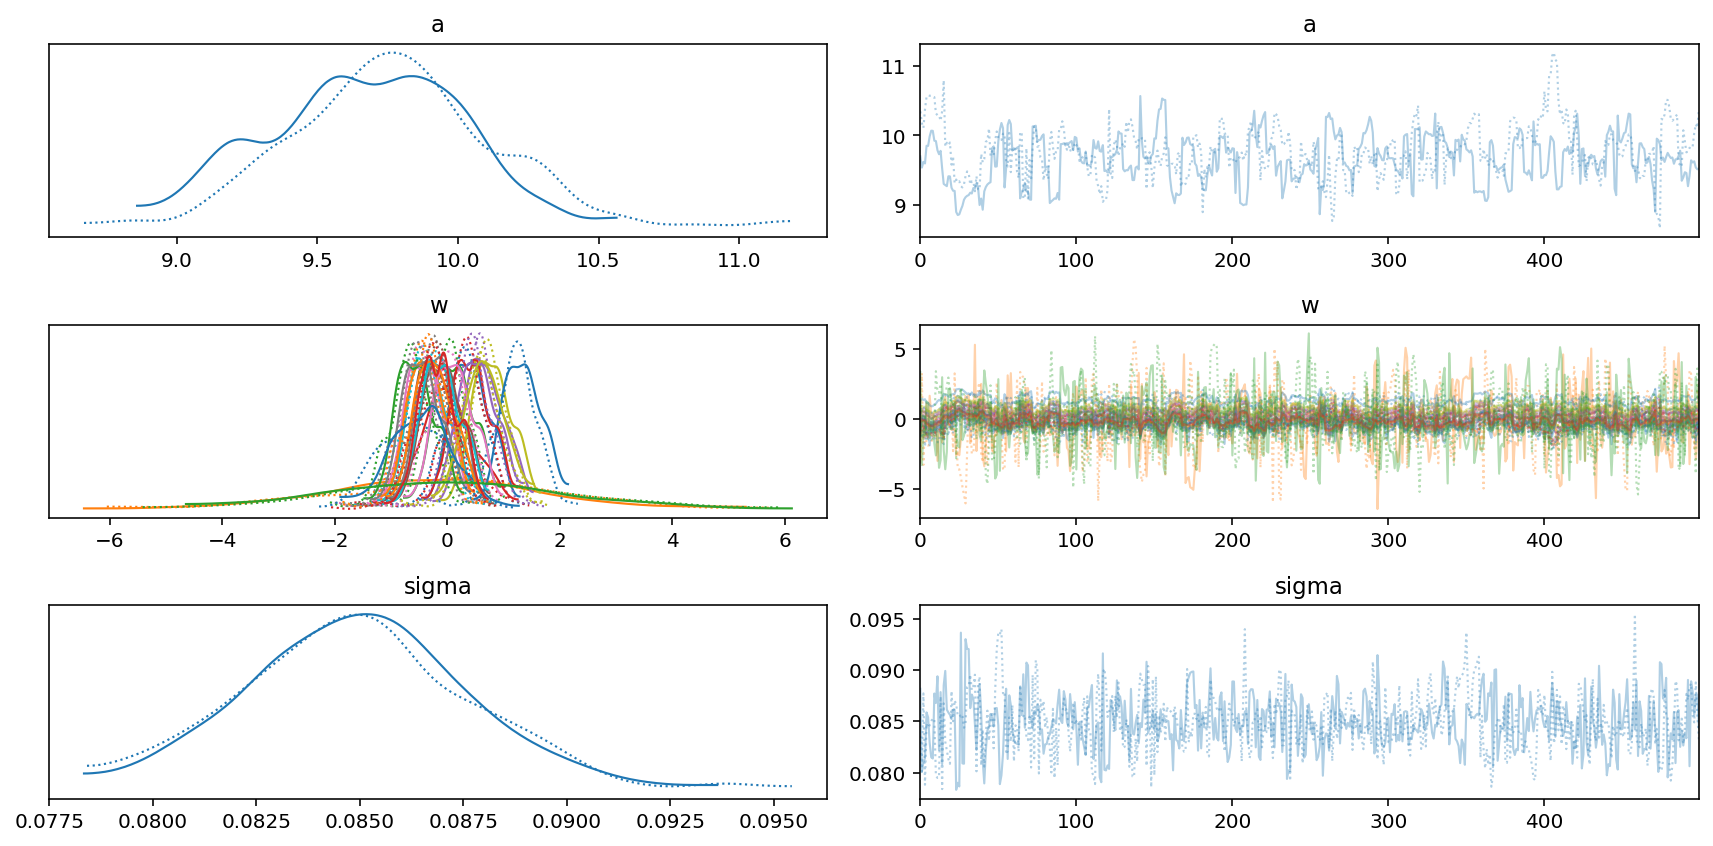

In [409]:
az.plot_trace(m3_trace, var_names=["~mu"])
plt.tight_layout();

In [410]:
az.summary(m3_trace, var_names=["~mu"], hdi_prob=HDI_PROB)

mean     sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  ess_bulk  \
a         9.719  0.361     9.174     10.305      0.032    0.023     131.0   
w[0, 0]   0.364  0.362    -0.170      0.965      0.033    0.023     129.0   
w[0, 1]  -0.133  1.982    -3.403      2.979      0.079    0.084     624.0   
w[1, 0]   0.077  0.364    -0.475      0.658      0.033    0.023     132.0   
w[1, 1]  -0.045  0.466    -0.793      0.707      0.034    0.024     187.0   
w[2, 0]   0.615  0.365     0.014      1.174      0.033    0.023     131.0   
w[2, 1]  -0.270  0.378    -0.846      0.360      0.032    0.025     149.0   
w[3, 0]  -0.441  0.363    -0.998      0.127      0.032    0.025     134.0   
w[3, 1]  -0.227  0.362    -0.748      0.370      0.033    0.025     130.0   
w[4, 0]   0.747  0.363     0.190      1.333      0.033    0.023     130.0   
w[4, 1]  -0.380  0.363    -0.960      0.176      0.032    0.025     132.0   
w[5, 0]   1.284  0.362     0.743      1.850      0.032    0.023     132.0   
w[5, 1]  -0.404  0.362    -0.910      0.229      0.033    0.025     130.0   
w[6, 0]  -0.613  0.364    -1.208     -0.066      0.032    0.024     138.0   
w[6, 1]   0.379  0.362    -0.206      0.938      0.032    0.023     133.0   
w[7, 0]   0.481  0.366    -0.058      1.077      0.033    0.023     132.0   
w[7, 1]  -0.132  0.363    -0.676      0.458      0.032    0.024     134.0   
w[8, 0]   0.069  0.364    -0.466      0.685      0.033    0.023     129.0   
w[8, 1]  -0.504  0.363    -1.063      0.078      0.033    0.025     130.0   
w[9, 0]   0.611  0.383     0.008      1.209      0.032    0.023     149.0   
w[9, 1]  -0.158  0.365    -0.722      0.422      0.032    0.025     135.0   
w[10, 0] -0.534  0.579    -1.459      0.406      0.038    0.028     230.0   
w[10, 1] -0.274  0.365    -0.862      0.273      0.033    0.025     132.0   
w[11, 0]  0.051  2.021    -2.667      3.921      0.079    0.067     651.0   
w[11, 1] -0.199  0.361    -0.737      0.402      0.032    0.025     132.0   
sigma     0.085  0.003     0.081      0.089      0.000    0.000     517.0   

          ess_tail  r_hat  
a            141.0   1.02  
w[0, 0]      121.0   1.02  
w[0, 1]      349.0   1.01  
w[1, 0]      152.0   1.02  
w[1, 1]      246.0   1.01  
w[2, 0]      152.0   1.02  
w[2, 1]      165.0   1.02  
w[3, 0]      135.0   1.02  
w[3, 1]      141.0   1.02  
w[4, 0]      133.0   1.02  
w[4, 1]      127.0   1.02  
w[5, 0]      122.0   1.02  
w[5, 1]      148.0   1.02  
w[6, 0]      187.0   1.02  
w[6, 1]      130.0   1.02  
w[7, 0]      128.0   1.02  
w[7, 1]      159.0   1.02  
w[8, 0]      120.0   1.02  
w[8, 1]      116.0   1.02  
w[9, 0]      226.0   1.01  
w[9, 1]      131.0   1.02  
w[10, 0]     549.0   1.02  
w[10, 1]     142.0   1.02  
w[11, 0]     536.0   1.00  
w[11, 1]     144.0   1.02  
sigma        498.0   1.00

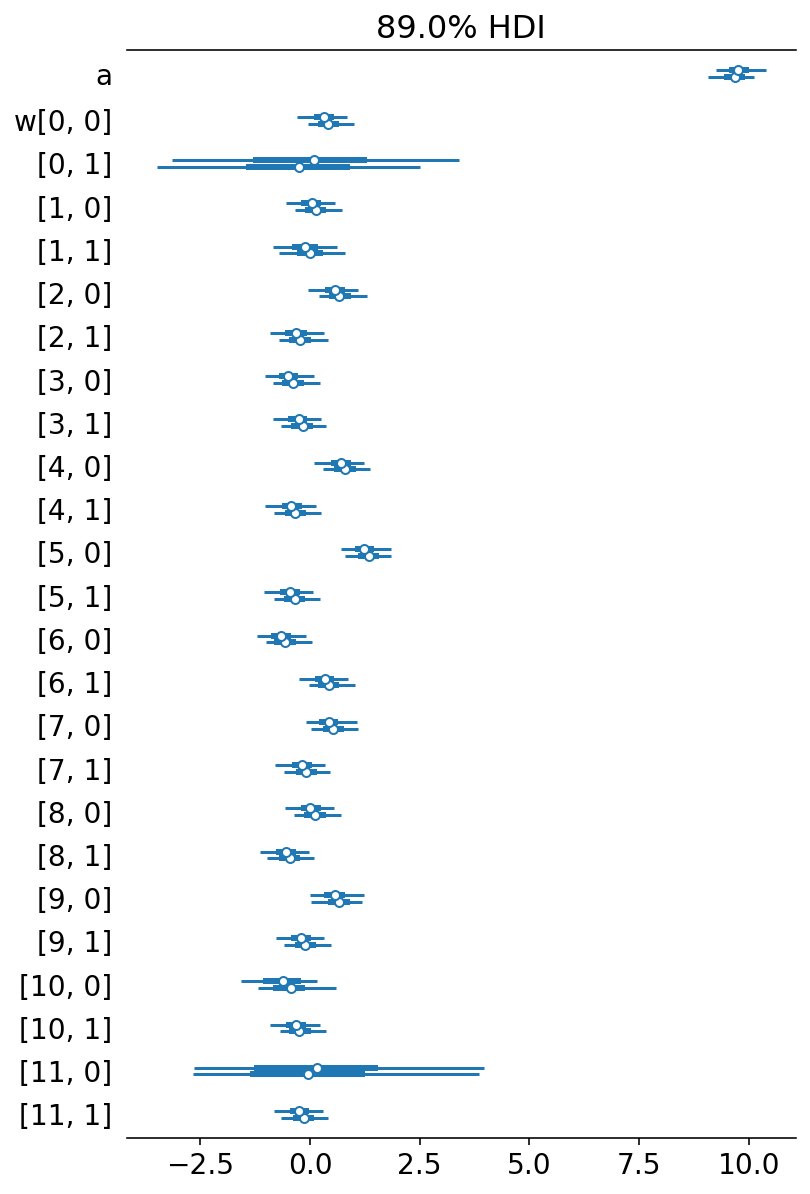

In [412]:
az.plot_forest(m3_trace, var_names=["a", "w"], hdi_prob=HDI_PROB);

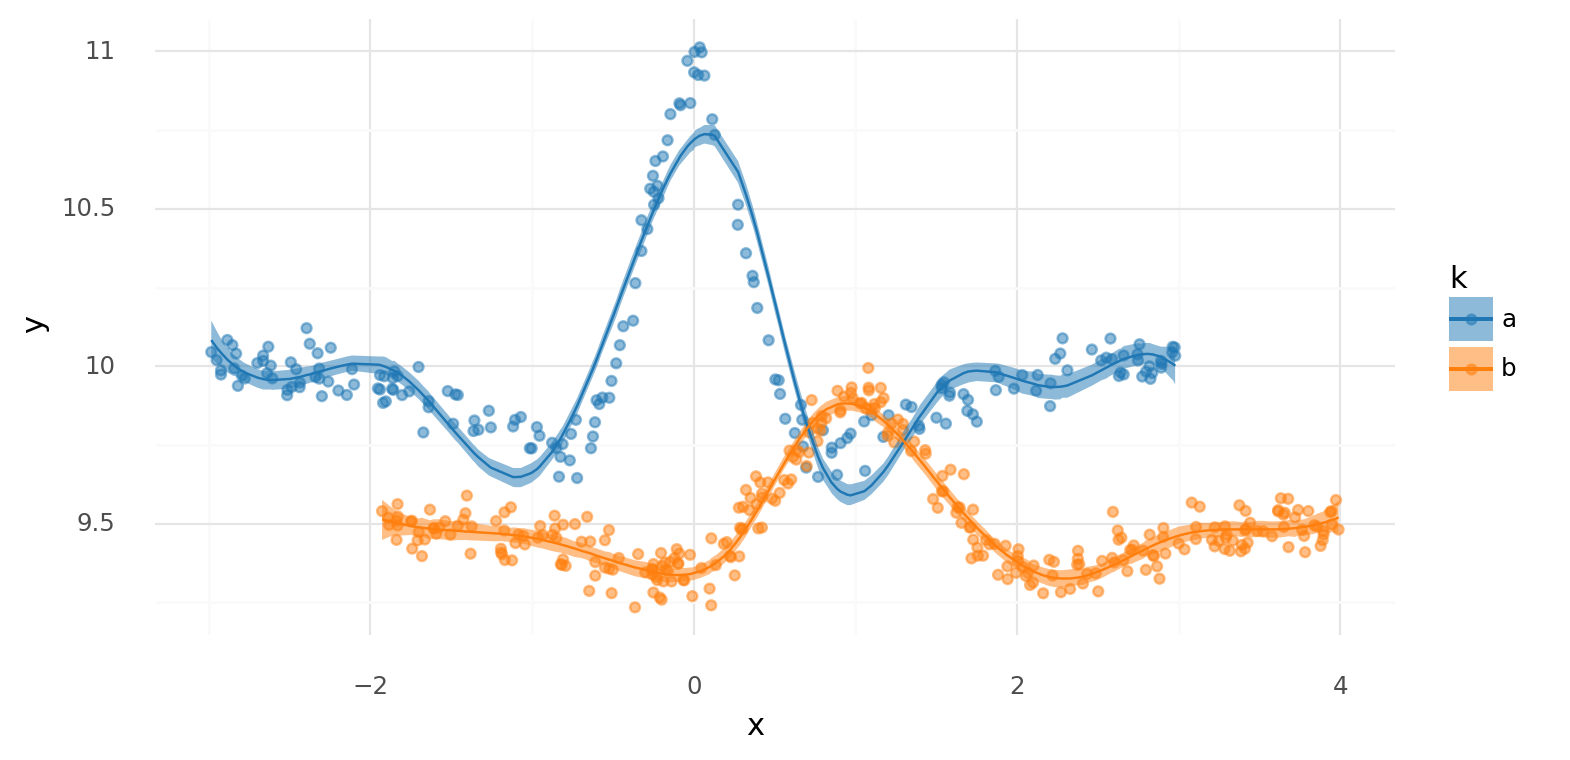

<ggplot: (362735692)>

In [413]:
_plot_posterior_mu(m3_trace, data=m3_data.data)

/var/folders/r4/qpcdgl_14hbd412snp1jnv300000gn/T/ipykernel_15931/2876986528.py:6: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions


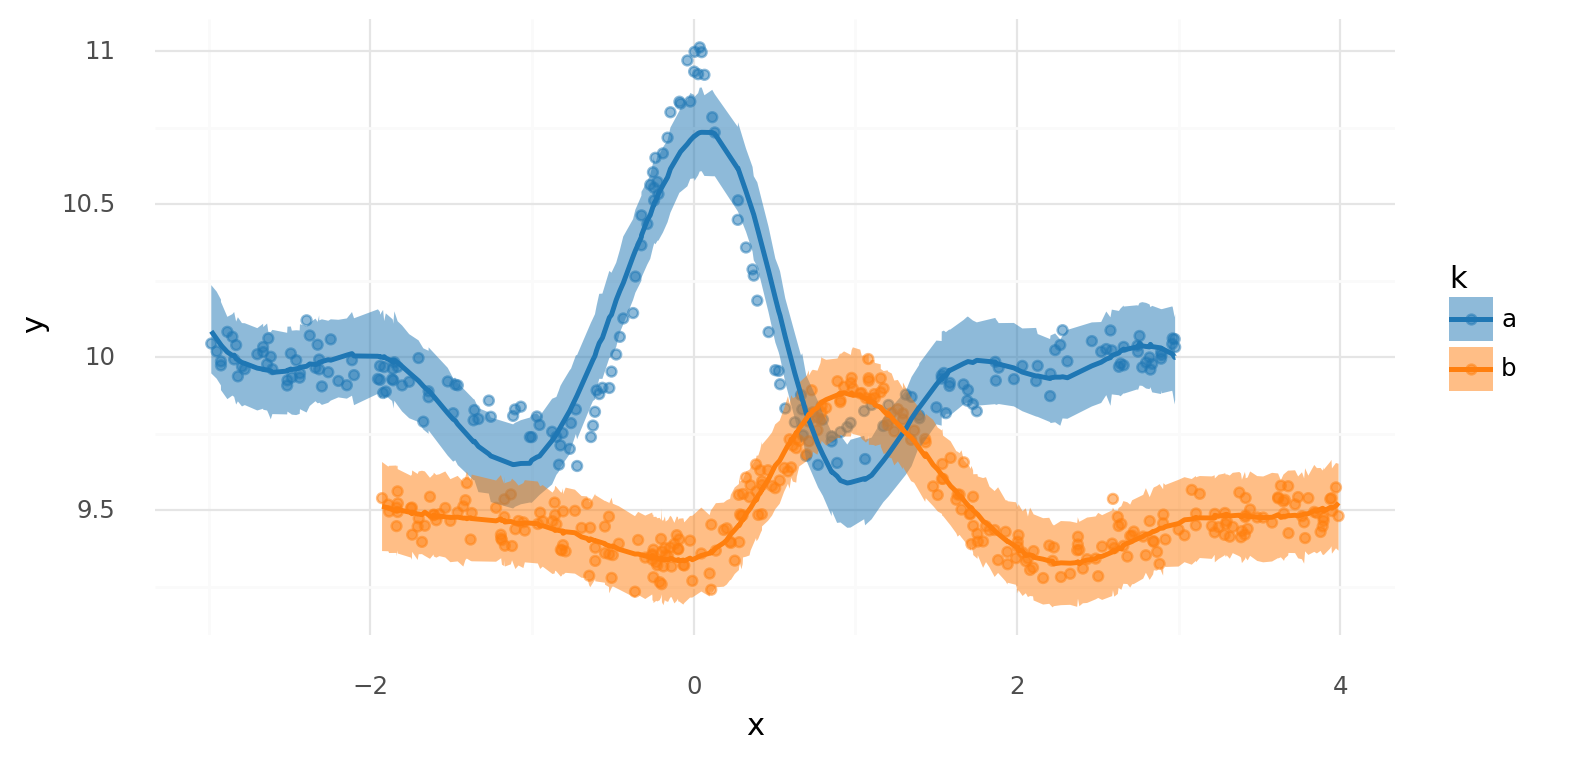

<ggplot: (362795439)>

In [414]:
_plot_ppc(m3_trace, m3_data.data)

### Out-of-distribution predictions

In [415]:
new_m3_data = _build_new_data(m3_data)
_data = new_m3_data.data.copy()
_data = pd.concat([_data.assign(k=k) for k in ["a", "b"]]).reset_index(drop=True)
_data["k"] = pd.Categorical(_data["k"], categories=["a", "b"], ordered=True)
new_m3_data.B = np.vstack([np.asarray(new_m3_data.B) for _ in range(2)])
new_m3_data.data = _data

In [416]:
with build_model3(new_m3_data):
    m3_post_pred_new = pm.sample_posterior_predictive(
        trace=m3_trace,
        var_names=["mu", "y"],
        return_inferencedata=True,
        extend_inferencedata=False,
        progressbar=False,
    )

/var/folders/r4/qpcdgl_14hbd412snp1jnv300000gn/T/ipykernel_15931/2876986528.py:6: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions


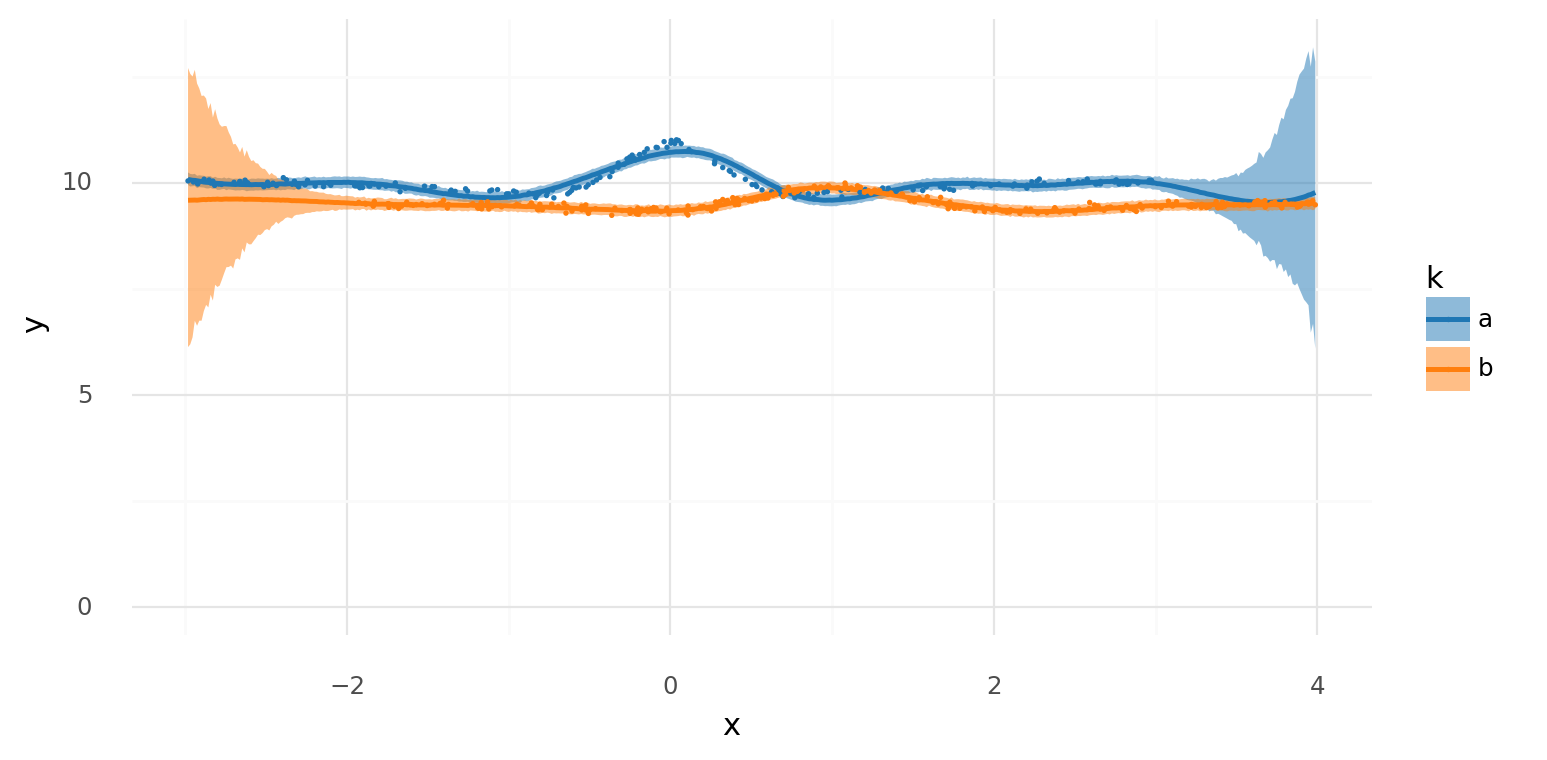

<ggplot: (362751916)>

In [417]:
(
    _plot_ppc(m3_post_pred_new, new_m3_data.data, pt_alpha=0)
    + gg.geom_point(gg.aes(x="x", y="y", color="k"), data=m3_data.data, size=0.1)
)

## Two groups: per-group weights with hierarchical prior

### Model #4

In [84]:
def build_model4(data: pd.DataFrame, B: np.ndarray) -> pm.Model:
    B_dim = B.shape[1]
    k = data.k.cat.codes.values.astype(int)
    n_k = len(data.k.cat.categories)
    with pm.Model(rng_seeder=RANDOM_SEED) as m4:
        mu_w = pm.Normal("mu_w", mu=0, sigma=5, shape=(B_dim, 1))
        sigma_w = pm.Gamma("sigma_w", 2.0, 0.5)
        w = pm.Normal(
            "w",
            at.horizontal_stack(*[mu_w for _ in range(n_k)]),
            sigma_w,
            shape=(B_dim, n_k),
        )
        _mu = []
        for i in range(n_k):
            _mu.append(pm.math.dot(B[k == i], w[:, i]).reshape((-1, 1)))
        mu = pm.Deterministic("mu", at.vertical_stack(*_mu).squeeze())
        sigma = pm.Gamma("sigma", 2, 0.5)
        y = pm.Normal("y", mu, sigma, observed=data.y.values)

    return m4

In [85]:
m4 = build_model4(data2, B3)
pm.model_to_graphviz(m4)

NameError: name 'B3' is not defined

### Sample from posterior

In [66]:
with build_model4(data=data2, B=np.asarray(B3)):
    m4_trace = pm.sample(**pm_sample_kwargs)
    pm.sample_posterior_predictive(m4_trace, **pm_ppc_kwargs)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_w, sigma_w, w, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 102 seconds.


### Posterior analysis

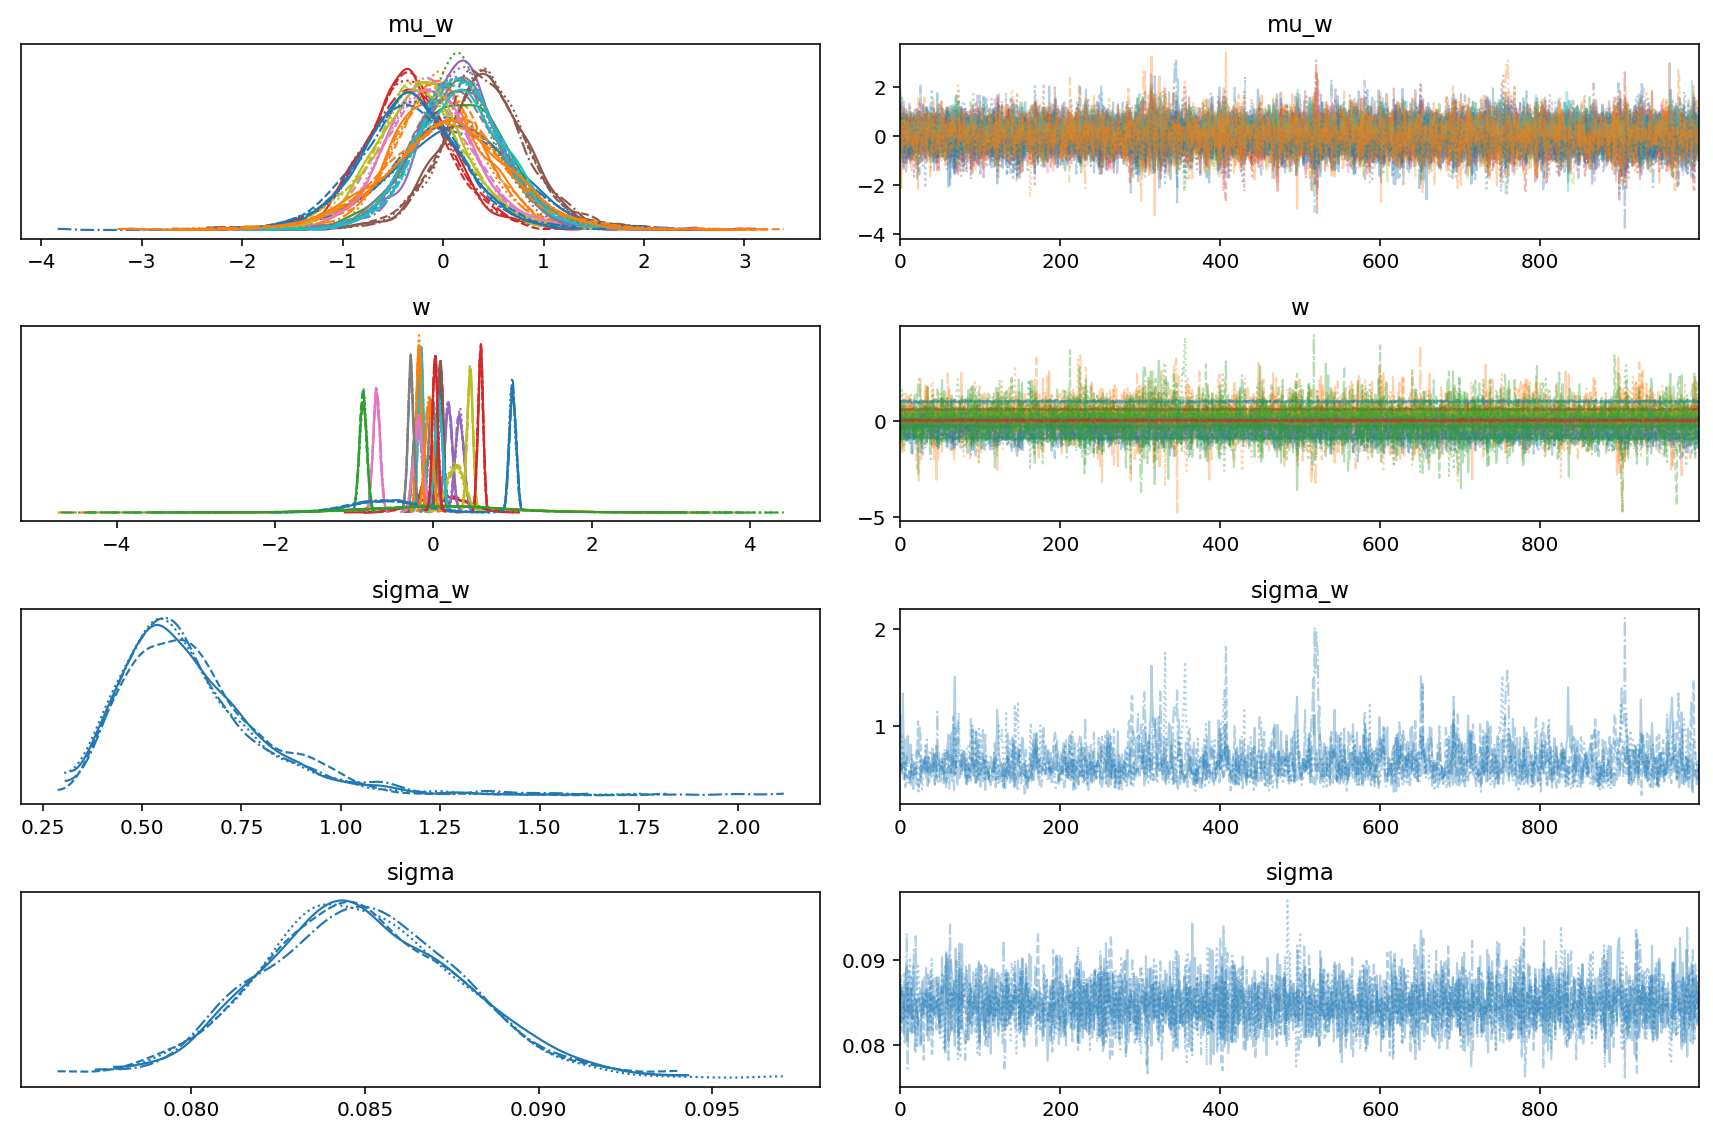

In [67]:
az.plot_trace(m4_trace, var_names=["~mu"])
plt.tight_layout();

In [68]:
az.summary(m4_trace, var_names=["~mu"], filter_vars="regex", hdi_prob=HDI_PROB)

mean     sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  ess_bulk  \
w[0, 0]   0.083  0.039     0.018      0.142      0.001    0.000    4444.0   
w[0, 1]   0.086  0.905    -1.281      1.555      0.015    0.016    4013.0   
w[1, 0]  -0.203  0.050    -0.283     -0.128      0.001    0.001    2899.0   
w[1, 1]   0.102  0.302    -0.404      0.565      0.006    0.005    2708.0   
w[2, 0]   0.331  0.053     0.246      0.414      0.001    0.001    2737.0   
w[2, 1]  -0.031  0.095    -0.184      0.120      0.002    0.001    2335.0   
w[3, 0]  -0.719  0.043    -0.789     -0.649      0.001    0.001    2983.0   
w[3, 1]  -0.014  0.044    -0.086      0.056      0.001    0.001    2229.0   
w[4, 0]   0.463  0.037     0.403      0.518      0.001    0.000    2851.0   
w[4, 1]  -0.158  0.032    -0.214     -0.111      0.001    0.000    2654.0   
w[5, 0]   1.001  0.041     0.939      1.070      0.001    0.001    2947.0   
w[5, 1]  -0.185  0.030    -0.234     -0.138      0.001    0.000    2798.0   
w[6, 0]  -0.889  0.044    -0.959     -0.819      0.001    0.001    3085.0   
w[6, 1]   0.596  0.032     0.539      0.644      0.001    0.000    2696.0   
w[7, 0]   0.190  0.047     0.111      0.261      0.001    0.001    2648.0   
w[7, 1]   0.090  0.035     0.031      0.142      0.001    0.000    2573.0   
w[8, 0]  -0.195  0.058    -0.289     -0.105      0.001    0.001    2401.0   
w[8, 1]  -0.286  0.036    -0.339     -0.224      0.001    0.001    2419.0   
w[9, 0]   0.283  0.107     0.111      0.451      0.002    0.002    2290.0   
w[9, 1]   0.066  0.048    -0.006      0.147      0.001    0.001    2198.0   
w[10, 0] -0.614  0.426    -1.322      0.026      0.008    0.006    2548.0   
w[10, 1] -0.060  0.047    -0.134      0.017      0.001    0.001    2558.0   
w[11, 0]  0.045  0.906    -1.421      1.359      0.015    0.016    3901.0   
w[11, 1]  0.021  0.034    -0.030      0.077      0.001    0.000    3548.0   
sigma_w   0.625  0.185     0.365      0.870      0.006    0.004    1075.0   
sigma     0.085  0.003     0.080      0.089      0.000    0.000    5613.0   

          ess_tail  r_hat  
w[0, 0]     3472.0    1.0  
w[0, 1]     2476.0    1.0  
w[1, 0]     3117.0    1.0  
w[1, 1]     2802.0    1.0  
w[2, 0]     2825.0    1.0  
w[2, 1]     2636.0    1.0  
w[3, 0]     3094.0    1.0  
w[3, 1]     2389.0    1.0  
w[4, 0]     2907.0    1.0  
w[4, 1]     2745.0    1.0  
w[5, 0]     3483.0    1.0  
w[5, 1]     2932.0    1.0  
w[6, 0]     3103.0    1.0  
w[6, 1]     3066.0    1.0  
w[7, 0]     2815.0    1.0  
w[7, 1]     2881.0    1.0  
w[8, 0]     2941.0    1.0  
w[8, 1]     2878.0    1.0  
w[9, 0]     2788.0    1.0  
w[9, 1]     2583.0    1.0  
w[10, 0]    2733.0    1.0  
w[10, 1]    2383.0    1.0  
w[11, 0]    2439.0    1.0  
w[11, 1]    3096.0    1.0  
sigma_w     1353.0    1.0  
sigma       2798.0    1.0

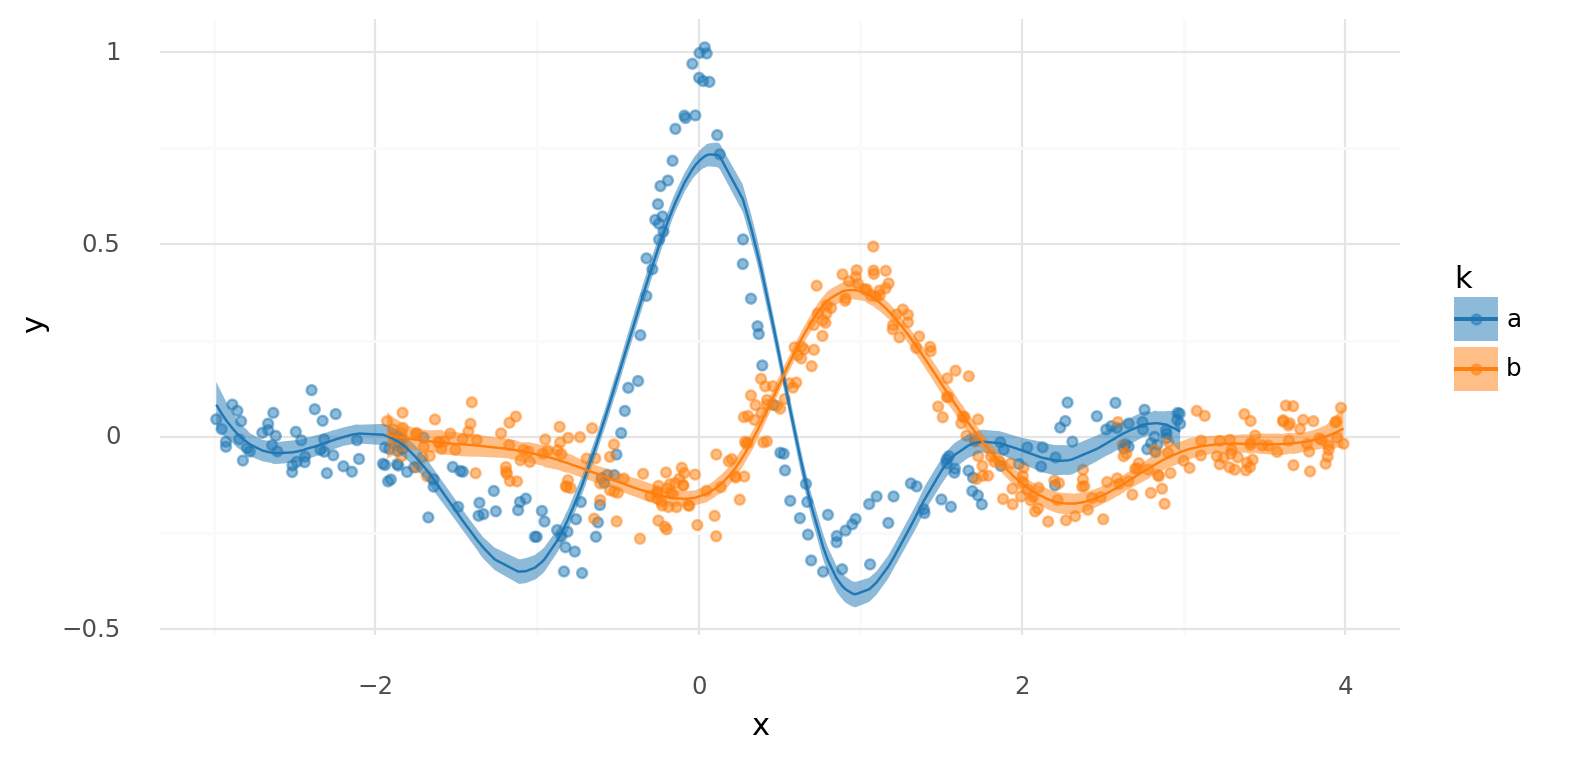

<ggplot: (346657949)>

In [69]:
_plot_posterior_mu(m4_trace, data=data2)

/var/folders/r4/qpcdgl_14hbd412snp1jnv300000gn/T/ipykernel_38106/2876986528.py:6: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions


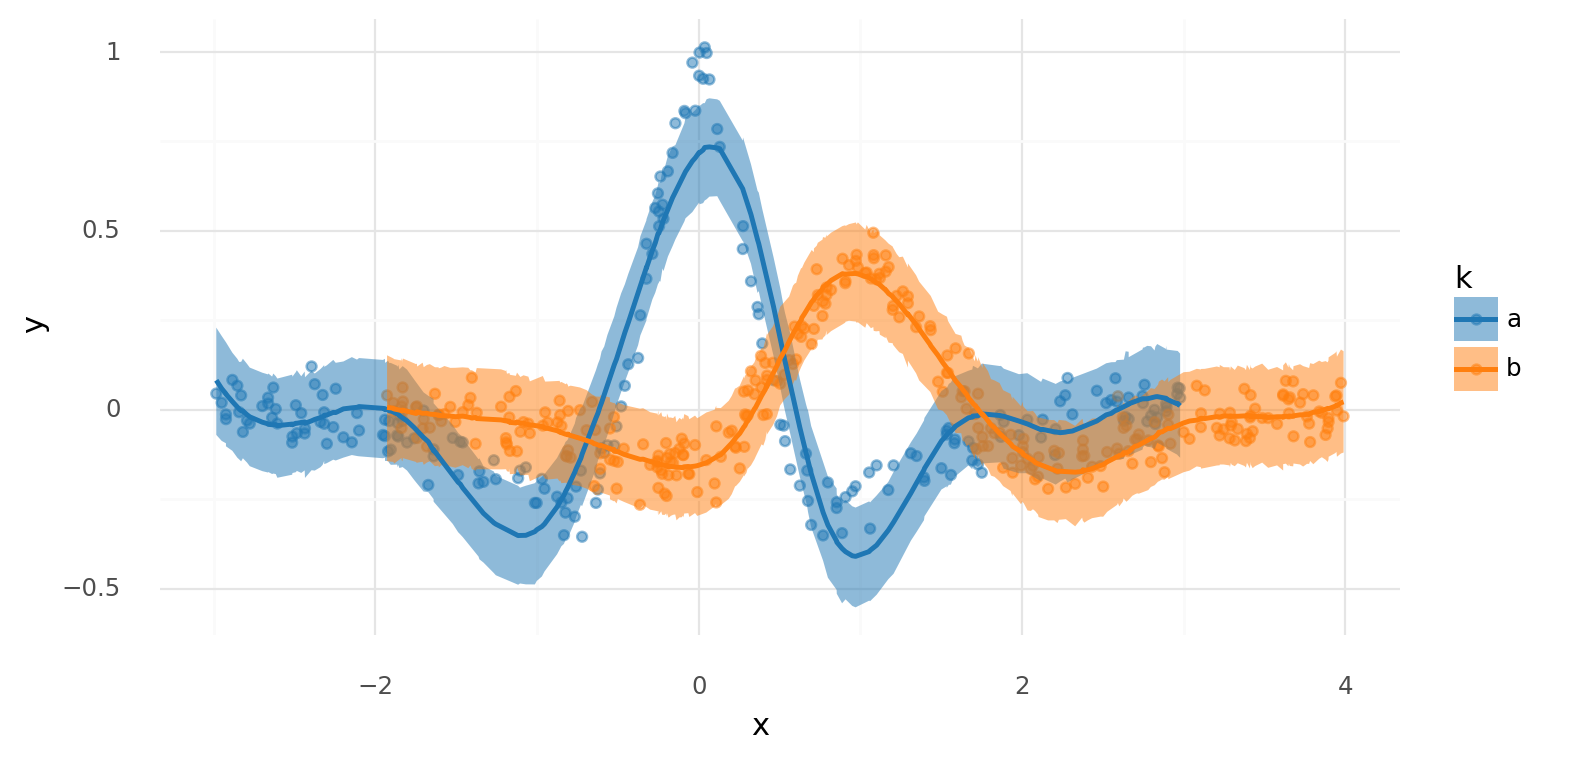

<ggplot: (347865853)>

In [70]:
_plot_ppc(m4_trace, data2)

### Out-of-distribution predictions

In [71]:
with build_model4(new_data3, B=new_B3_array):
    m4_post_pred_new = pm.sample_posterior_predictive(
        trace=m4_trace,
        var_names=["mu", "y"],
        return_inferencedata=True,
        extend_inferencedata=False,
    )

/var/folders/r4/qpcdgl_14hbd412snp1jnv300000gn/T/ipykernel_38106/2876986528.py:6: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
/usr/local/Caskroom/miniconda/base/envs/speclet/lib/python3.9/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/usr/local/Caskroom/miniconda/base/envs/speclet/lib/python3.9/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/usr/local/Caskroom/miniconda/base/envs/speclet/lib/python3.9/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/usr/local/Caskroom/miniconda/base/envs/speclet/lib/python3.9/si

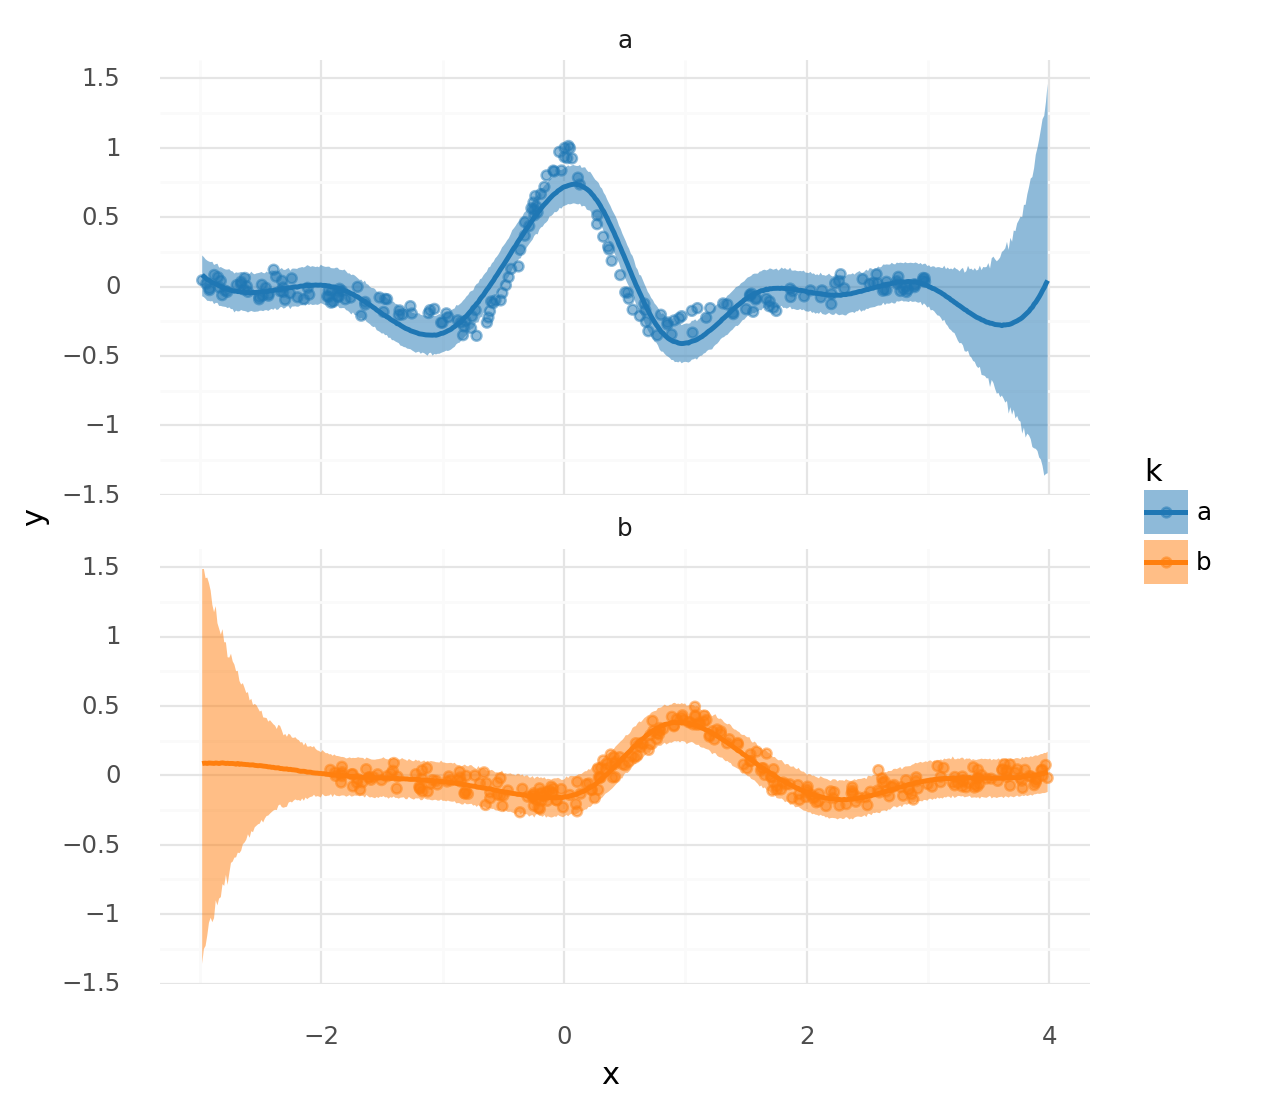

<ggplot: (349094946)>

In [72]:
(
    _plot_ppc(m4_post_pred_new, new_data3, pt_alpha=0)
    + gg.facet_wrap("~k", ncol=1)
    + gg.geom_point(gg.aes(x="x", y="y", color="k"), data=data2, alpha=0.5)
    + gg.theme(figure_size=(6, 6))
)

## One group: multivariate-normal prior on weights

> This is still a WIP.

### Model #5 simple

In [266]:
def build_model5_simple(data: pd.DataFrame, B: np.ndarray) -> pm.Model:
    B_dim = B.shape[1]
    with pm.Model(rng_seeder=RANDOM_SEED) as m5:
        mu_w = pm.Normal("mu_w", 0, 2.5)
        sigma_w = pm.Gamma("sigma_w", 2, 0.5)
        a = pm.Normal("a", 0, 5)
        w = pm.Normal("w", mu_w, sigma_w, shape=B_dim)
        mu = pm.Deterministic("mu", a + pm.math.dot(np.asarray(B), w.T))
        sigma = pm.Gamma("sigma", 2, 0.5)
        y = pm.Normal("y", mu, sigma, observed=data.y)
    return m5

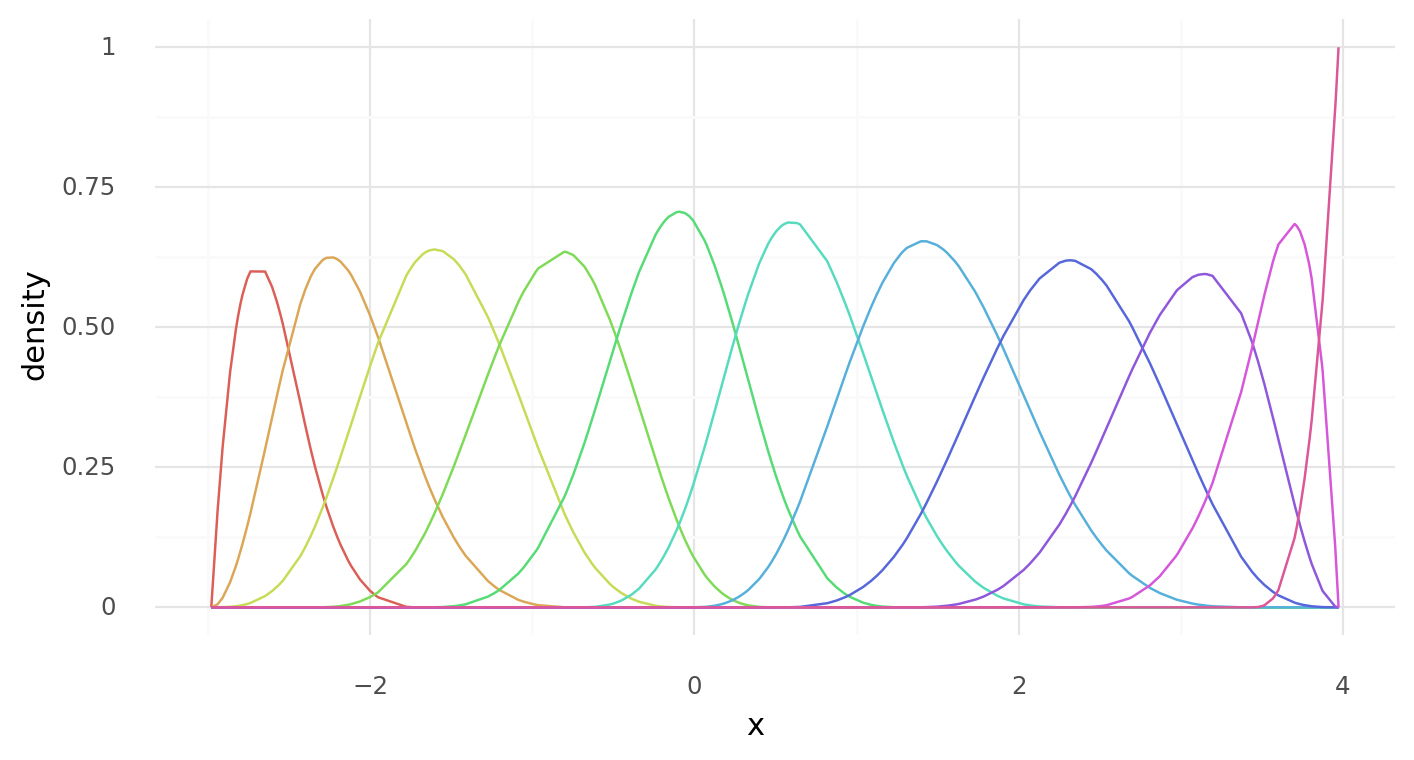

<ggplot: (371145686)>

In [268]:
basis_df = (
    pd.DataFrame(np.asarray(B))
    .reset_index(drop=False)
    .assign(x=data.x.values)
    .pivot_longer(index=["index", "x"], names_to="basis", values_to="density")
)

(
    gg.ggplot(basis_df, gg.aes(x="x", y="density", color="basis"))
    + gg.geom_line()
    + gg.theme(legend_position="none")
)

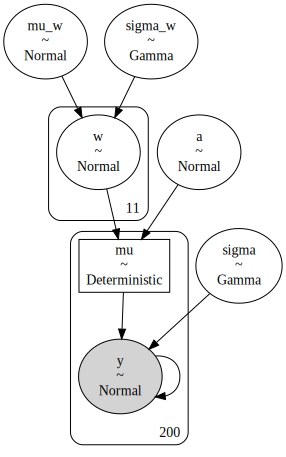

In [269]:
m5_s = build_model5_simple(data, B)
pm.model_to_graphviz(m5_s)

### Sample from posterior

In [270]:
with build_model5_simple(data=data, B=np.asarray(m5_s_B)):
    m5_s_trace = pm.sample(**pm_sample_kwargs)
    pm.sample_posterior_predictive(m5_s_trace, **pm_ppc_kwargs)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_w, sigma_w, a, w, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 78 seconds.
The number of effective samples is smaller than 25% for some parameters.


### Posterior analysis

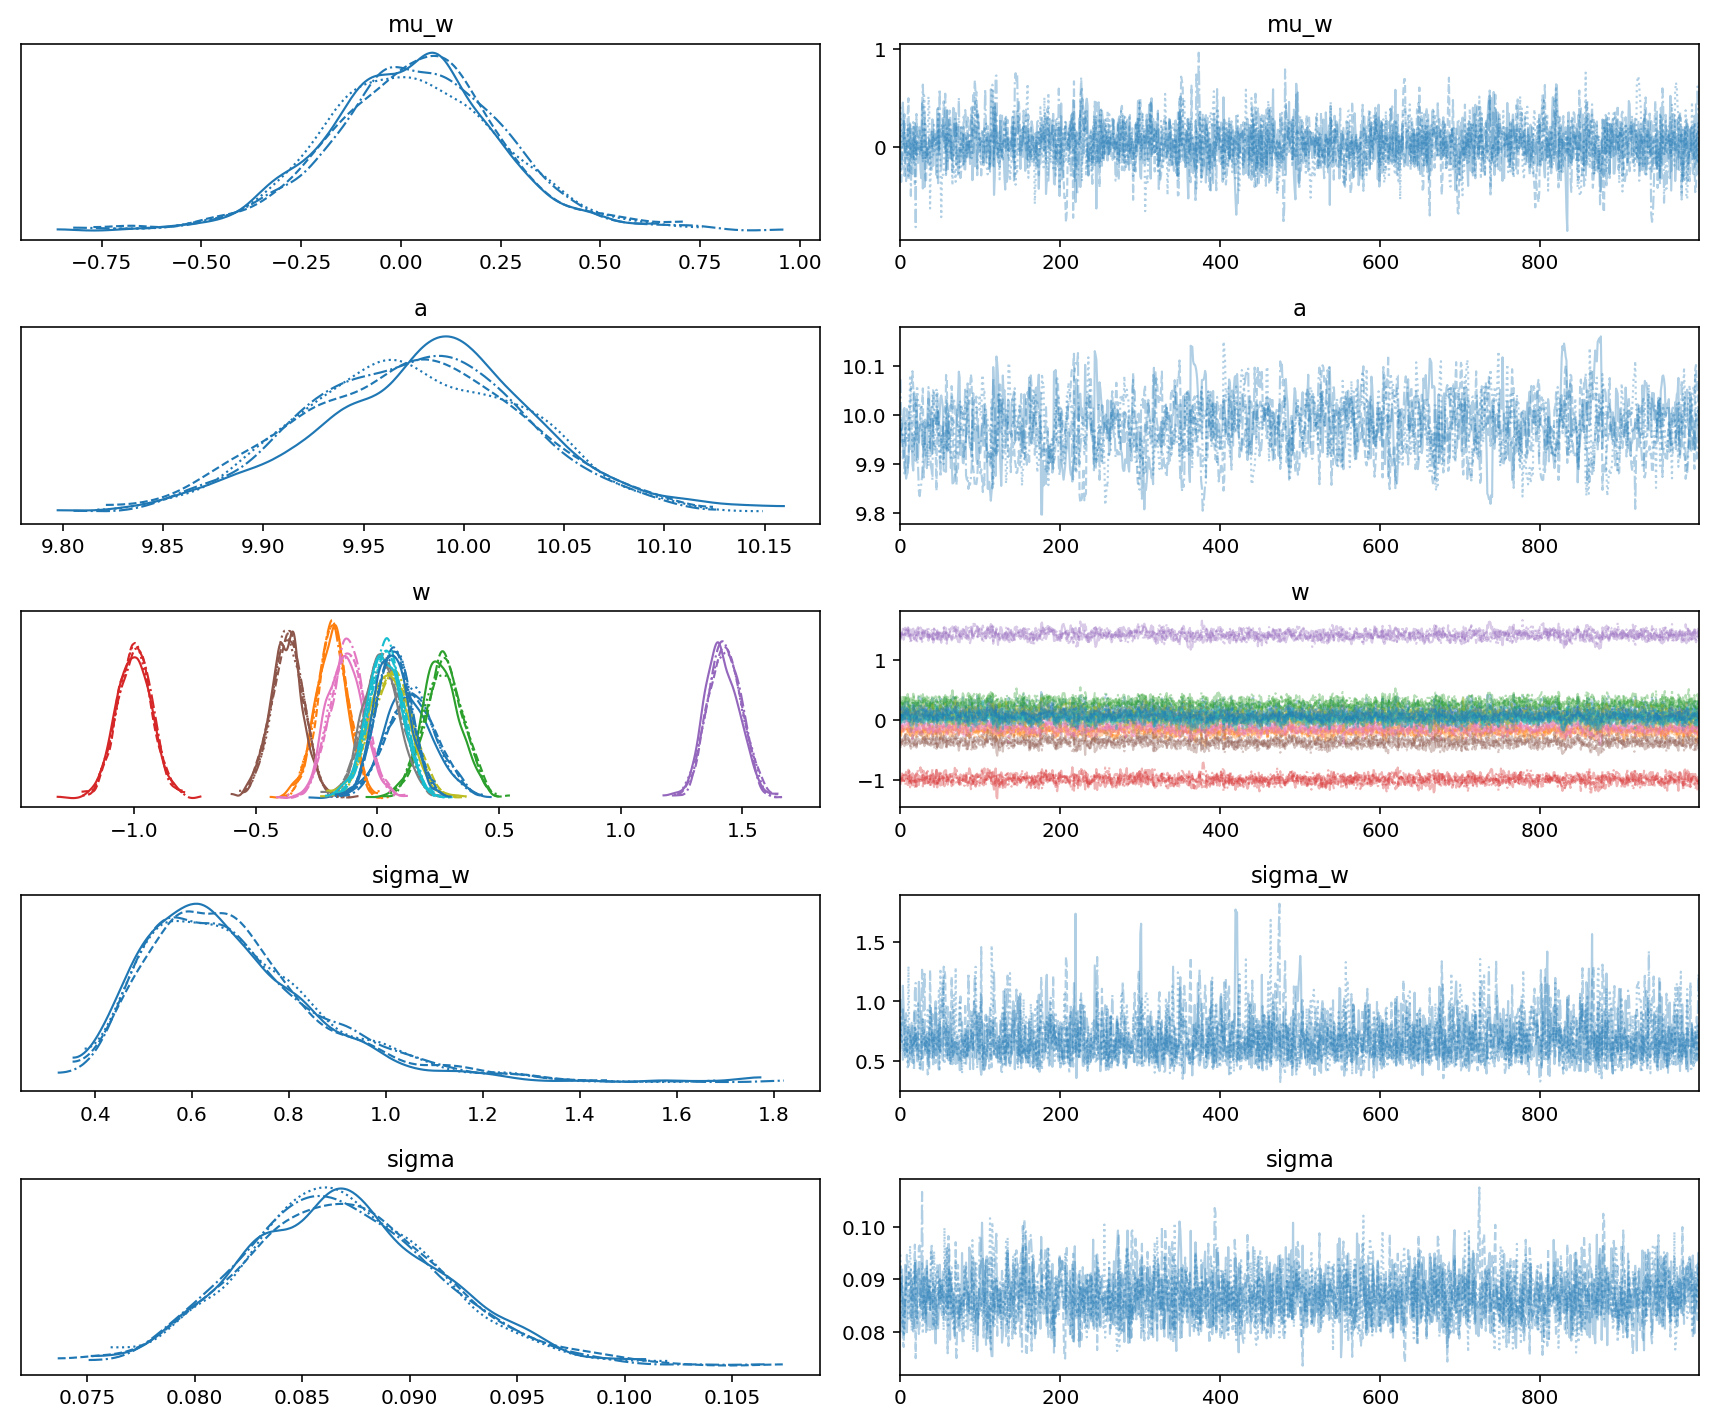

In [271]:
az.plot_trace(m5_s_trace, var_names=["~mu"])
plt.tight_layout();

### Model #5 multivariate normal

In [182]:
def build_model5_mv(data: pd.DataFrame, B: np.ndarray) -> pm.Model:
    B_dim = B.shape[1]
    _B_ary = np.asarray(B)
    with pm.Model(rng_seeder=RANDOM_SEED) as m5_mv:
        _sd_dist = pm.Gamma.dist(2, 0.5, shape=B_dim)
        chol, corr, stds = pm.LKJCholeskyCov(
            "chol", eta=2, n=B_dim, sd_dist=_sd_dist, compute_corr=True
        )
        cov = pm.Deterministic("cov", chol.dot(chol.T))

        mu_w = pm.Normal("mu_w", 0, 2.5, shape=B_dim)
        delta_w = pm.Normal("delta_w", 0, 1, shape=B_dim)
        # w = pm.MvNormal("w", mu=mu_w, chol=chol, shape=B_dim)
        w = pm.Deterministic("w", mu_w + at.dot(chol, delta_w.T).T)

        mu = pm.Deterministic("mu", pm.math.dot(_B_ary, w))
        sigma = pm.Gamma("sigma", 2, 0.5)
        y = pm.Normal("y", mu, sigma, observed=data.y)
    return m5_mv

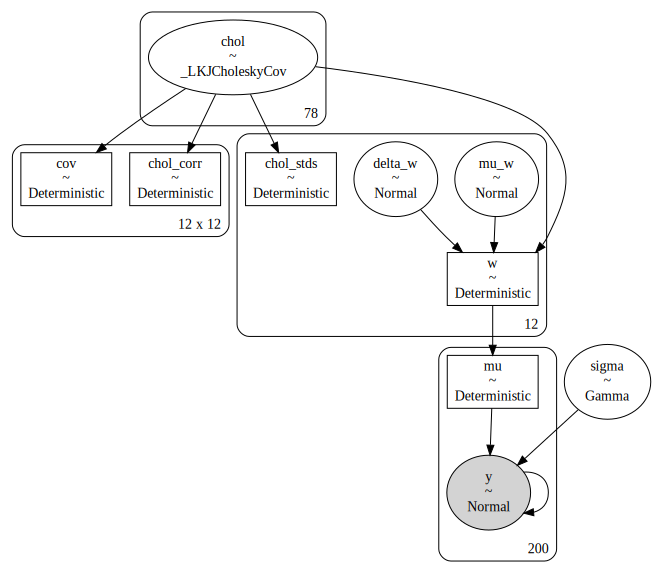

In [183]:
m5_mv = build_model5_mv(data, B)
pm.model_to_graphviz(m5_mv)

### Sample from posterior

In [184]:
with build_model5_mv(data=data, B=np.asarray(B)):
    m5_mv_trace = pm.sample(**pm_sample_kwargs)
    pm.sample_posterior_predictive(m5_mv_trace, **pm_ppc_kwargs)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [chol, mu_w, delta_w, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1376 seconds.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.


### Posterior analysis

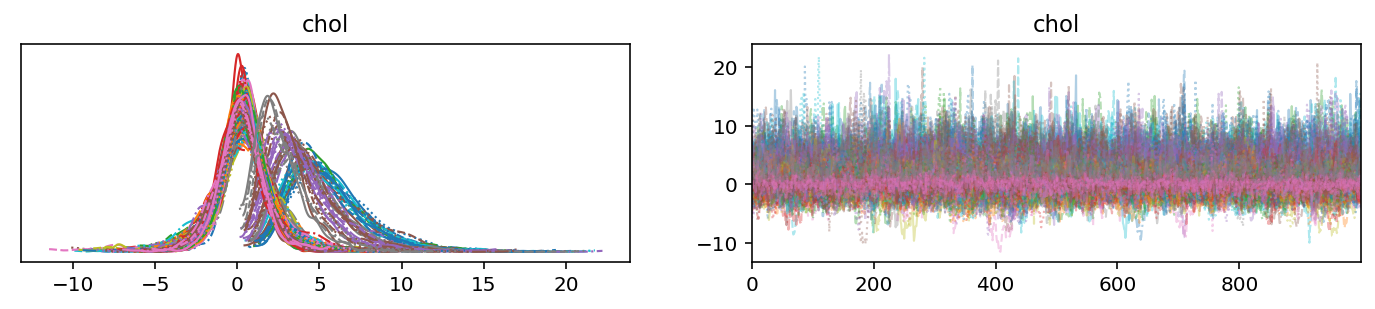

In [188]:
az.plot_trace(m5_mv_trace, var_names=["chol"]);

In [189]:
# az.plot_trace(m5_mv_trace, var_names=["~mu", "~delta_w"])
# plt.tight_layout();

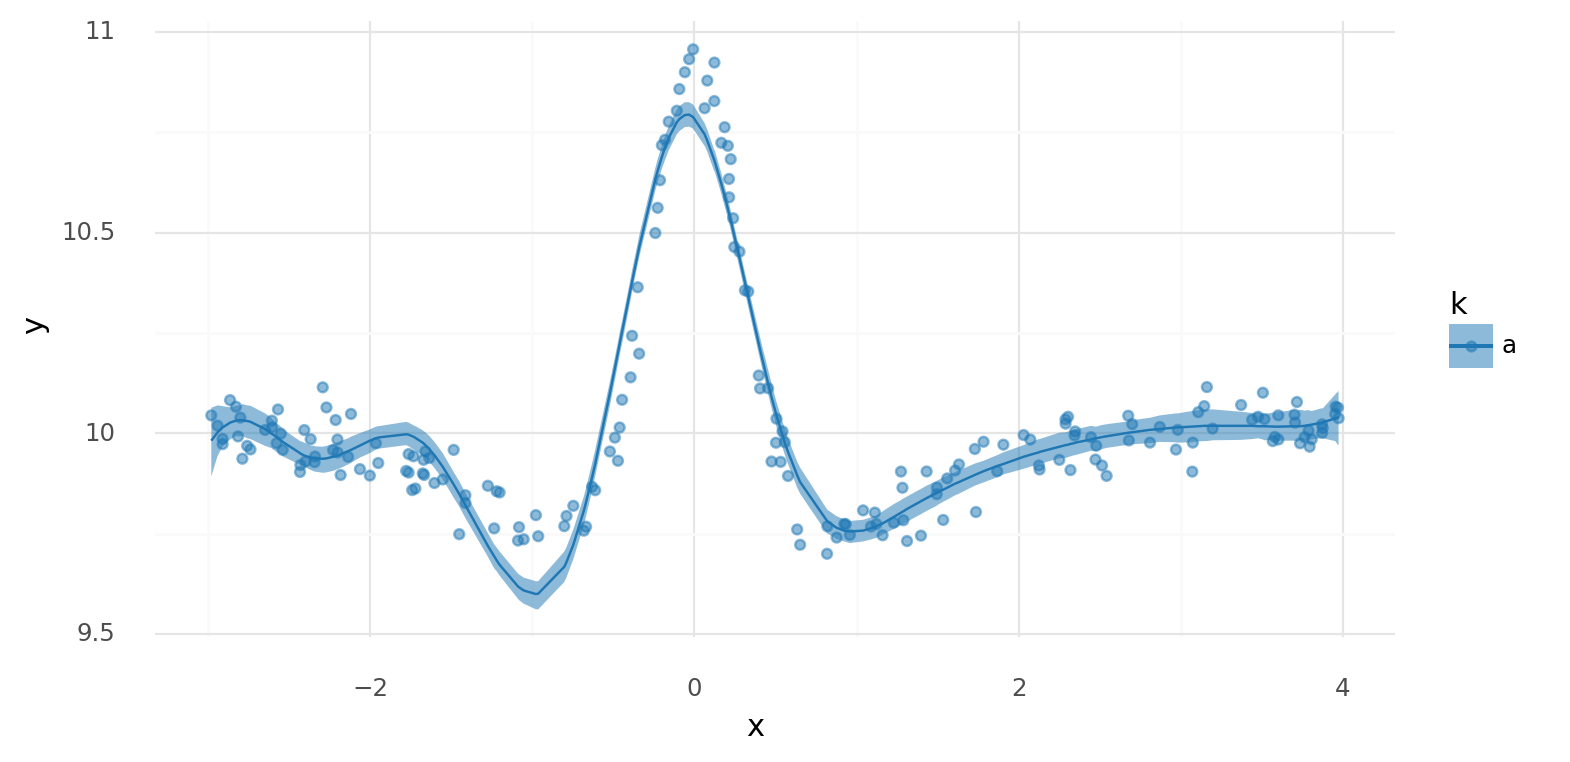

<ggplot: (360906632)>

In [190]:
_plot_posterior_mu(m5_s_trace, data=data)

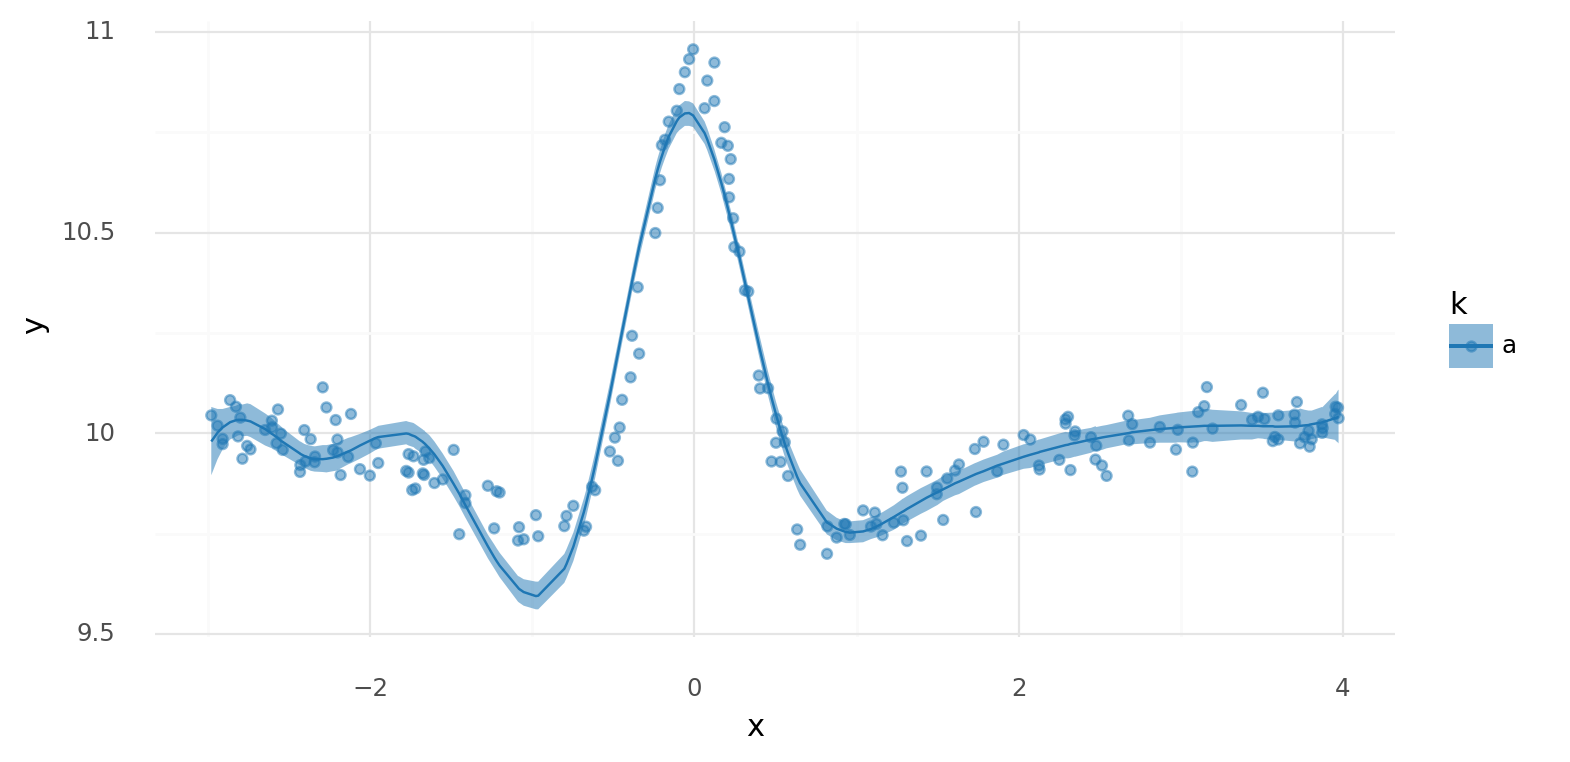

<ggplot: (360895413)>

In [191]:
_plot_posterior_mu(m5_mv_trace, data=data)

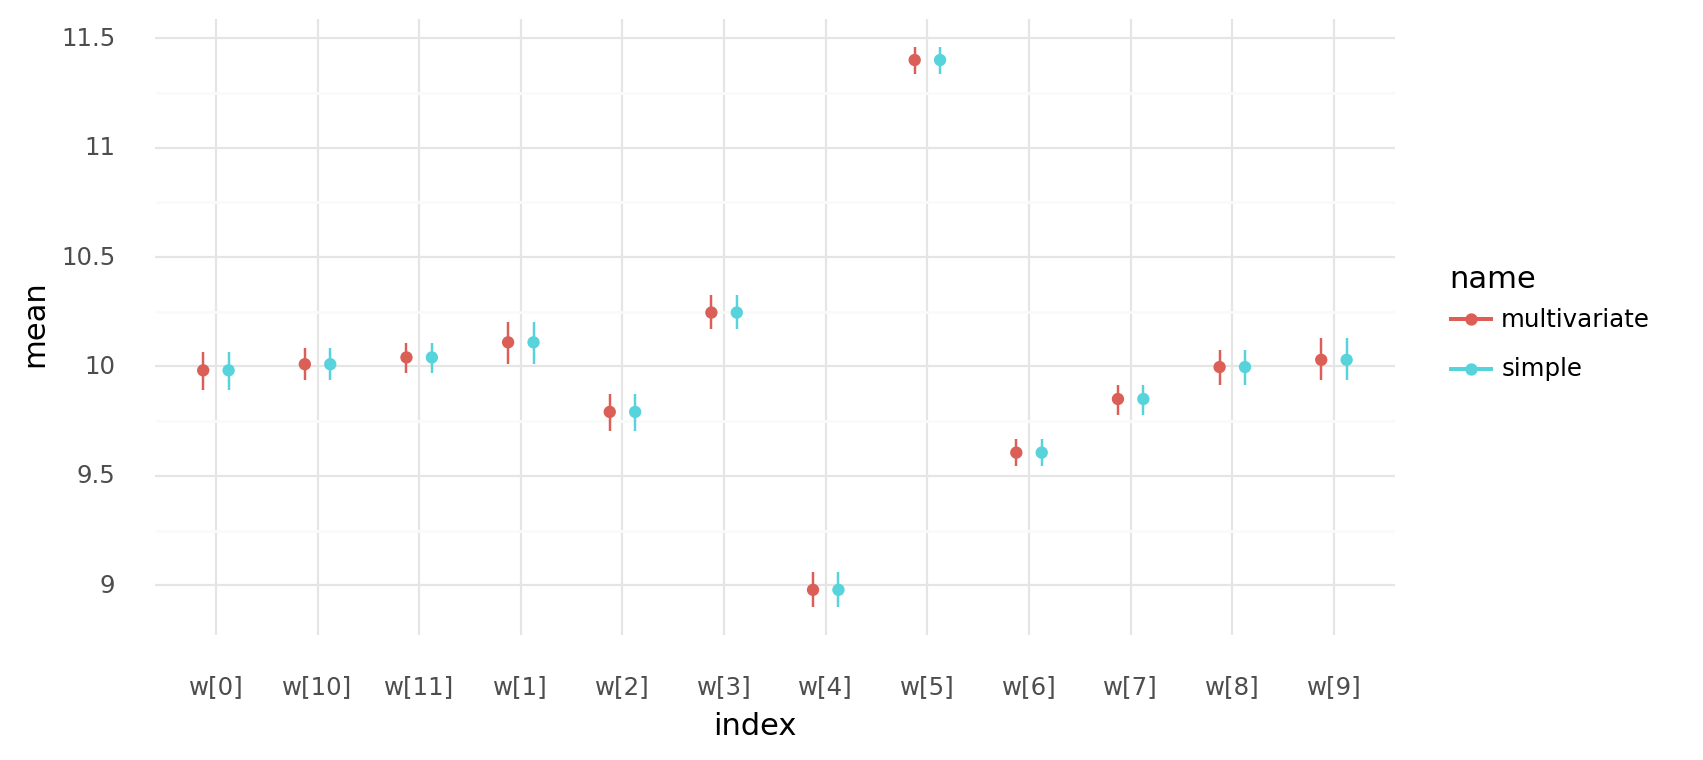

<ggplot: (360839506)>

In [192]:
w_post_combined = pd.concat(
    [
        az.summary(m5_s_trace, var_names=["w"], kind="stats", hdi_prob=HDI_PROB).assign(
            name=n
        )
        for n, t in {"simple": m5_s_trace, "multivariate": m5_mv_trace}.items()
    ]
).reset_index(drop=False)

pos = gg.position_dodge(0.5)
(
    gg.ggplot(w_post_combined, gg.aes(x="index", y="mean", color="name"))
    + gg.geom_linerange(gg.aes(ymin="hdi_5.5%", ymax="hdi_94.5%"), position=pos)
    + gg.geom_point(position=pos)
)

In [204]:
cov_post_df = (
    az.summary(m5_mv_trace, var_names=["cov"], hdi_prob=HDI_PROB)
    .reset_index(drop=False)
    .rename(columns={"index": "parameter"})
    .assign(_idx=lambda d: [list(re.findall("[0-9]+", x)) for x in d.parameter])
    .assign(
        d0=lambda d: [int(x[0]) for x in d["_idx"]],
        d1=lambda d: [int(x[1]) for x in d["_idx"]],
    )
)
cov_post_df.head()

parameter    mean      sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  \
0  cov[0, 0]  39.864  36.979     1.973     80.004      1.670    1.182   
1  cov[0, 1]   3.312   9.167   -10.967     16.396      0.373    0.264   
2  cov[0, 2]   2.651  10.406   -12.795     15.994      0.426    0.301   
3  cov[0, 3]   3.092  11.069   -10.014     20.573      0.512    0.365   
4  cov[0, 4]   2.991   9.429   -10.982     15.637      0.508    0.359   

   ess_bulk  ess_tail  r_hat    _idx  d0  d1  
0     353.0     636.0   1.01  [0, 0]   0   0  
1     592.0     831.0   1.01  [0, 1]   0   1  
2     680.0     666.0   1.01  [0, 2]   0   2  
3     608.0     386.0   1.00  [0, 3]   0   3  
4     509.0     414.0   1.01  [0, 4]   0   4

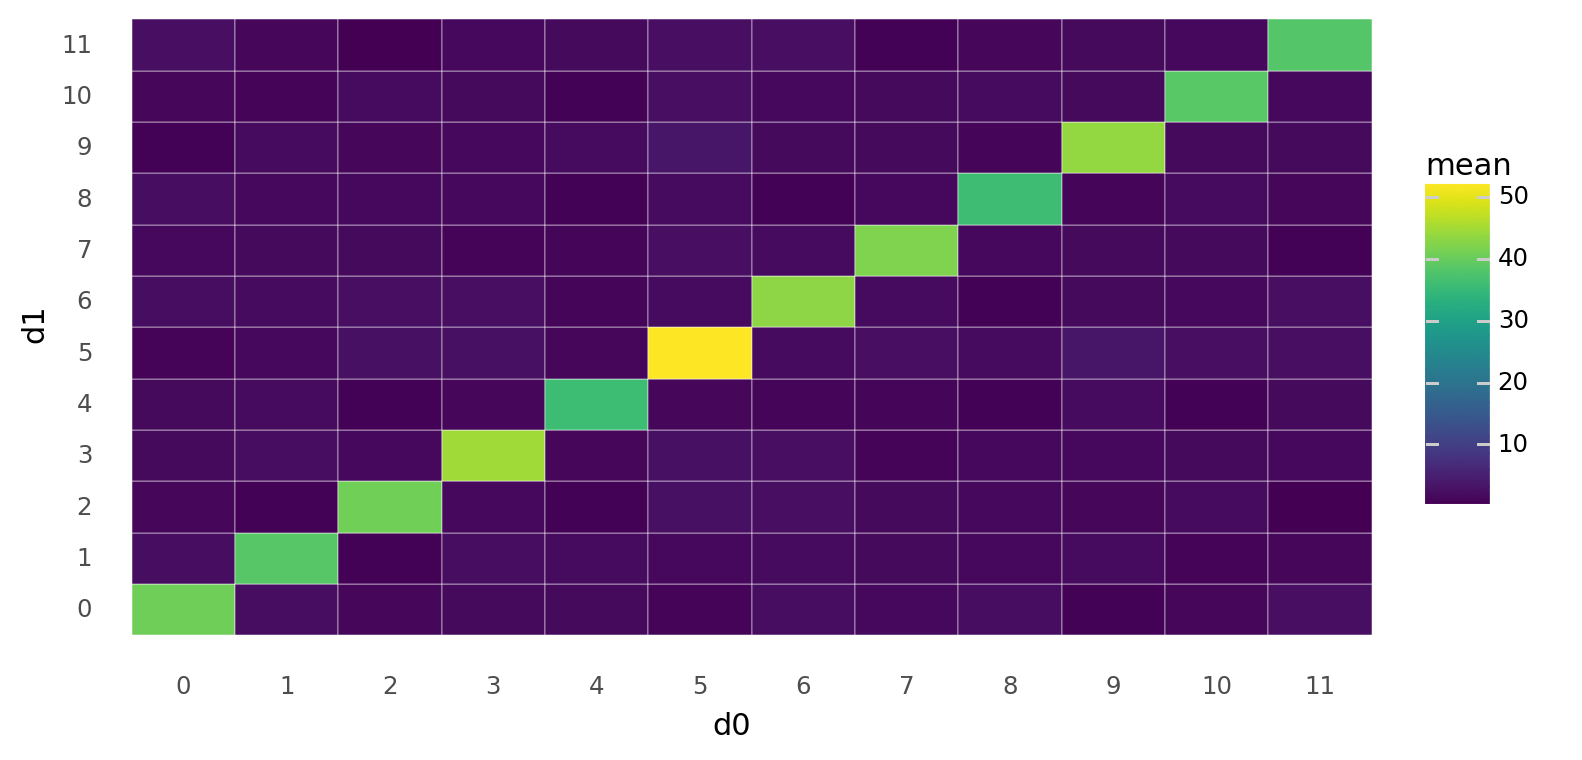

<ggplot: (362921500)>

In [212]:
(
    gg.ggplot(cov_post_df, gg.aes(x="d0", y="d1"))
    + gg.geom_tile(gg.aes(fill="mean"), color="white")
    + gg.scale_x_continuous(expand=(0, 0), breaks=np.arange(0, 100))
    + gg.scale_y_continuous(expand=(0, 0), breaks=np.arange(0, 100))
)

---

## Session info

In [77]:
%load_ext watermark
%watermark -d -u -v -iv -b -h -m

Last updated: 2022-02-21

Python implementation: CPython
Python version       : 3.9.9
IPython version      : 8.0.1

Compiler    : Clang 11.1.0 
OS          : Darwin
Release     : 21.3.0
Machine     : x86_64
Processor   : i386
CPU cores   : 4
Architecture: 64bit

Hostname: JHCookMac

Git branch: add-nb-model

plotnine  : 0.8.0
pandas    : 1.4.1
arviz     : 0.11.4
matplotlib: 3.5.1
pymc      : 4.0.0b2
aesara    : 2.3.8
janitor   : 0.22.0
scipy     : 1.7.3
seaborn   : 0.11.2
numpy     : 1.22.2

